# Capstone Project (Used Car Price Prediction) 

## Part 1 
### Data Cleaning 
-[Cleaning](#cleaning) 
  
## Part 2
### Exploratory Analysis & Data Preprocessing 

-[Preprocessing](#prepro)

-[Exploratory Analysis](#explo)
   
-[Integrating Country Data](#country)
   
   
## Part 3 
-[Visualization](#viz)
  - Distribution of Price per Year 
  - Distribution of Mileage per Make
  - Distribution of Horsepower per Make 
       
## Part 4 
-[Machine Learning](#ml)

  
-[Residual Plots](#res)
       
       

In [114]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import scipy
%config InlineBackend.figure_format='retina'
%matplotlib inline
import warnings
from sklearn import tree
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import multicomp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

In [115]:
# Snapshot of the dataset
span_cars = pd.read_csv('spanish_cars.csv',sep=';')
span_cars.head(3)


,ID,make,model,version,months_old,power,sale_type,num_owners,gear_type,fuel_type,kms,price
0,97860,Porsche,911,Carrera 4 S Coup�,240.0,210.0,classic,3.0,manual,gasoline,202000.0,999999
1,27821,Ford,Mustang,Gt500 Cabrio Vendido,54.0,487.0,used,1.0,manual,gasoline,30000.0,685000
2,97801,Porsche,911,3.3 Turbo Targa (Precio A Consultar),358.0,220.0,used,NaN,manual,gasoline,56300.0,555555


## Part 1 - Cleaning Data
<a id='cleaning' ></a>

- In this section, I mostly focus on cleaning out nulls and duplicates from my data. I also decided to fill some of the gear_type and fuel_type nulls with 'unknown'. I am assuming that these people ("unknown) chose not or forgot to specify these categories while listing their cars on the website. 

- I also drop 3 columns, num_owners, sale_type and version as #1 they have high numbers of nulls and #2 are not beneficial variables for the purpose of predicting the price of used cars. 

In [116]:
#Explore nulls 
span_cars.columns
print(span_cars.isnull().sum())
#Fill some nulls with unknown for these two categories (I am using these for my analysis)
span_cars['gear_type'].fillna(value='unknown',inplace=True)
span_cars['fuel_type'].fillna(value='unknown',inplace=True)
print(span_cars.isnull().sum())
#Drop num_owners, sales_type (useless columns for analysis & too many nulls)
span_cars.drop(columns=['num_owners','sale_type','version'],inplace=True)
#Drop Duplicates
span_cars.drop_duplicates(inplace=True)
#Drop nulls for remaining columns 
span_cars.dropna(inplace=True)
print(span_cars.isnull().sum())


ID                0
make              0
model             0
version           0
months_old      274
power           487
sale_type        12
num_owners    71331
gear_type      1281
fuel_type        65
kms             864
price             0
dtype: int64
ID                0
make              0
model             0
version           0
months_old      274
power           487
sale_type        12
num_owners    71331
gear_type         0
fuel_type         0
kms             864
price             0
dtype: int64
ID            0
make          0
model         0
months_old    0
power         0
gear_type     0
fuel_type     0
kms           0
price         0
dtype: int64


<a id='prepro' ></a>

## Part 2 -  Exploratory Analysis & Preprocessing

   - In this section, I work on changing the months_old column to a more interpretable format (Resampling dates). I converted the months_old column to an "age" column which represents the model year of the car. (i.e. If you are selling a 2006 Honda, the age column would say "2006" instead of 144 months old. 
   
   
   - In addition, I also remove outliers from the data such as brand new cars with 0 kms i.e. mileage. Note: I don't remove outliers for the price and other columns as the goal of my project is to predict the price of any car, essentially to allow my mode to able to generalize on any kind of unseen data. 
   
   
   - I then start to plot out different distributions data to better understand its underlying distribution and gain a better understanding of how I want to approach feature engineering for my models. 

In [117]:
# Used car analysis, remove brand new cars 
span = span_cars[(span_cars['kms'] > 0)]
span['months_old'].astype(int)
twelve = np.ceil((span.months_old/12)).astype(float) # round up some are less than 1 month old
span_new = pd.merge(span,twelve.to_frame(),left_index=True,right_index=True)
span_new.drop(columns=['months_old_x'],inplace=True)
span_new.rename(columns={'months_old_y':'age'}, inplace=True) # age is the year of model of the vehicle
span_new = span_new[(span_new['age'] < 32.0)]
year = (2018-span_new.age).to_frame()
span_new = pd.merge(span,year,left_index=True,right_index=True)
#span_new is the new dataset with the appropriate age column

In [118]:
print(span_new.age.unique())

[ 1998.  2013.  1988.  2016.  2017.  2015.  1997.  1992.  2005.  2014.
  2010.  2011.  2002.  2009.  2012.  2000.  2007.  2006.  1990.  1987.
  1996.  2008.  1995.  1994.  2003.  2004.  1991.  1993.  2001.  1989.
  1999.]


<a id='explo' ></a>


### Distribution Plots
   - In this section, I assess how the "numeric/continuous" independent variables are distributed. I also inspect the frequencies for my categorical variables. 

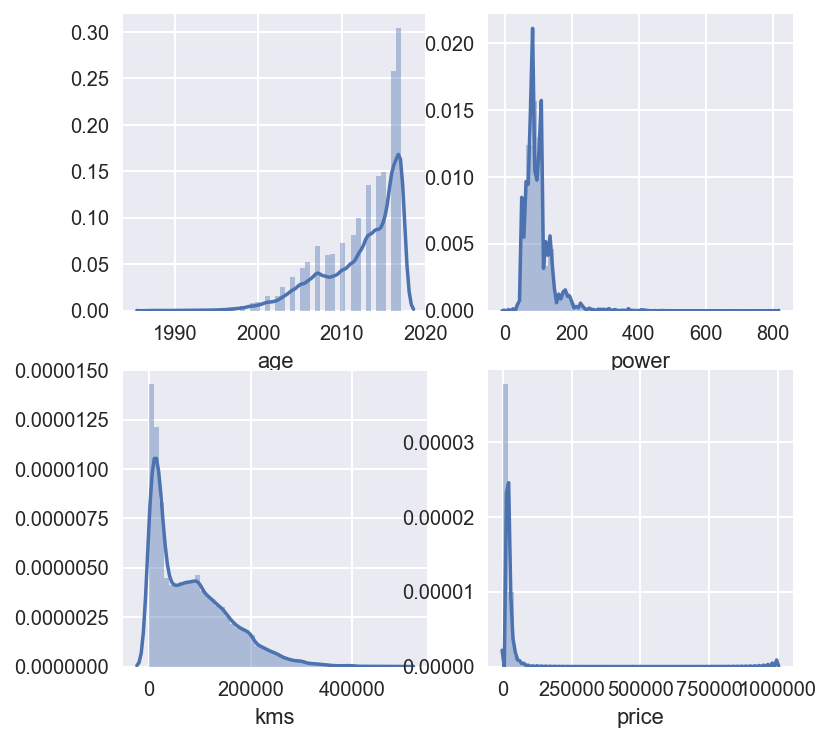

In [119]:
# Plotting out distributions for the numeric variables to see whether they are normally distributed
warnings.filterwarnings("ignore")
sns.set()
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(ncols=2,nrows=2,figsize=(6,6)) 
sns.distplot(span_new['age'],ax=ax1);
sns.distplot(span_new['power'],ax=ax2);
sns.distplot(span_new['kms'],ax=ax3);            
sns.distplot(span_new['price'],ax=ax4);


### Frequency Plots 
 - In this section, I inspect the frequency of the different categorical variables to get a better understanding of their distribution and potentially drop some variables that may act as outliers. 

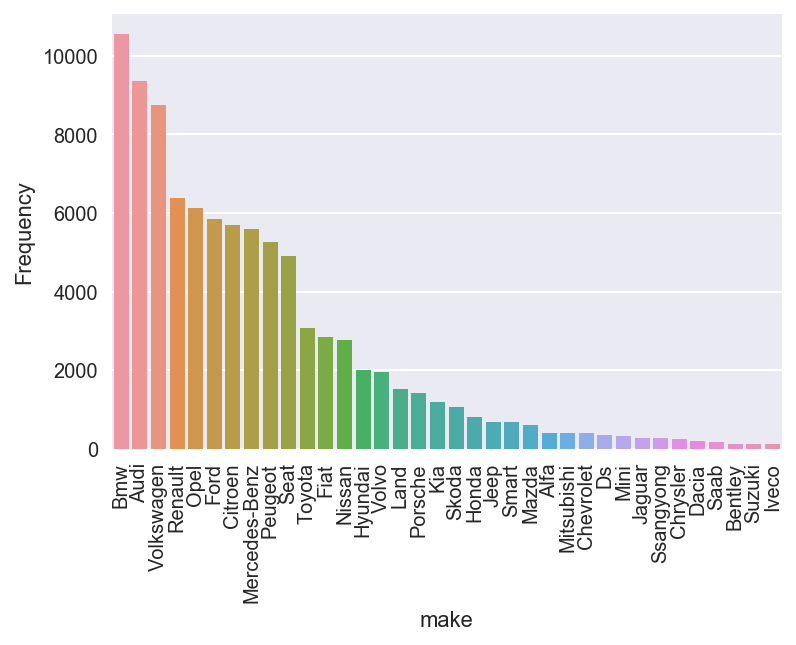

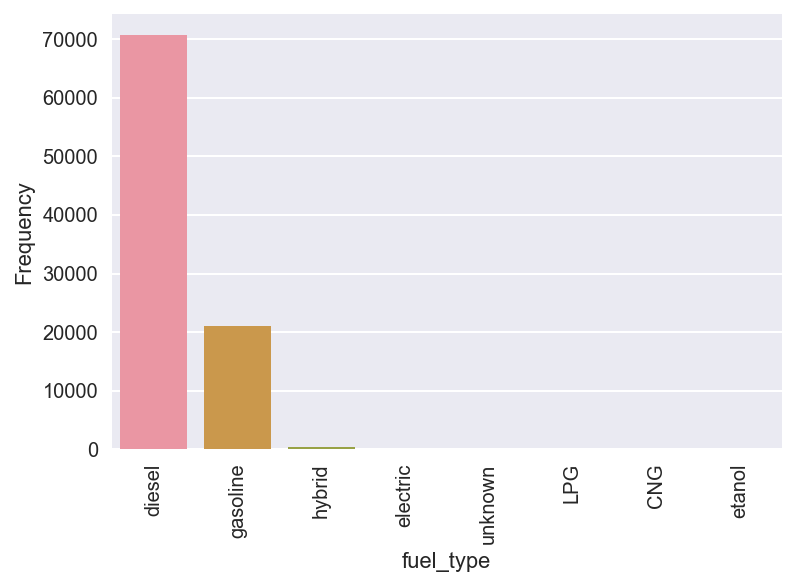

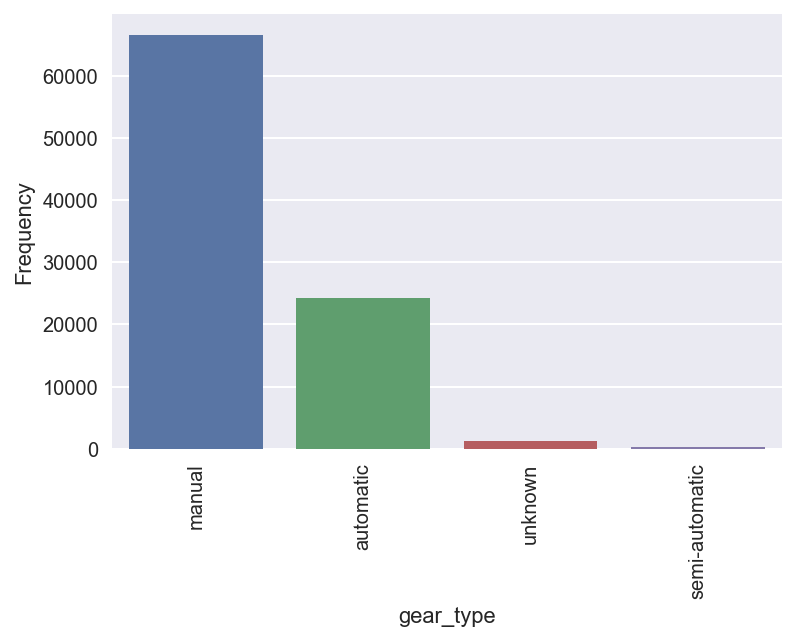

In [120]:
categories = ['make','fuel_type', 'gear_type'] # categorical features used in my analysis
ranges = [0,1,2,3,4] 
counts = []
x = []
y = []
for i,j in zip(ranges,categories):
    z = span_new.groupby([j])['ID'].count().sort_values(ascending=False).reset_index()
    counts.append(z)
    x.append(counts[i][j])
    y.append(counts[i]['ID'])
    plt.figure()
    sns.barplot(x[i],y[i])
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    

### Further Cleaning & Preprocessing
   - Based off the above frequency plots, I notice some categories may act "outliers" due to very low counts.
   - I decided to drop two fuel_type categories, etanol & CNG. (low frequency, very imbalanced) 
   - I decided to keep all of the categories within gear type.
   - Lastly, I clean the outcome variable column 'price', from any outliers such as cars priced over 400,000 euros or less than 0 euros. 

#### Cleaning Fuel Type

In [121]:
# Based off the above graphs, a few things caught my attention in the fuel_type section (Etanol & CNG)
print(span_new.groupby(['fuel_type'])['ID'].count().sort_values(ascending=True).reset_index())
# It seems like a safe option to drop Etanol and CNG 
et = span_new[(span_new['fuel_type']=='etanol')].index
cng = span_new[(span_new['fuel_type']=='CNG')].index
span_new.drop(et,axis=0,inplace=True) # etanol 
span_new.drop(cng,axis=0,inplace=True) # CNG 
print(span_new.groupby(['fuel_type'])['ID'].count().sort_values(ascending=True).reset_index())


  fuel_type     ID
0    etanol      1
1       CNG      3
2       LPG     43
3   unknown     53
4  electric     92
5    hybrid    470
6  gasoline  21028
7    diesel  70699
  fuel_type     ID
0       LPG     43
1   unknown     53
2  electric     92
3    hybrid    470
4  gasoline  21028
5    diesel  70699


#### Cleaning Gear Type

In [122]:
#Not Very Infrequent,  So I am going to keep the semi-automatic rows
print(span_new.groupby(['gear_type'])['ID'].count().sort_values(ascending=True).reset_index())

        gear_type     ID
0  semi-automatic    292
1         unknown   1234
2       automatic  24275
3          manual  66584


#### Cleaning Price

In [123]:
span_new = span_new.drop(span_new[span_new.price>400000].index)

<a id='country' ></a>


### Integrating more data - Countries

In [124]:
# I just add countries to my data to increase the amount of data and do some more analysis at the country-level.
#Here, each car maker gets a corresponding country assigned.
Germany = {'Audi','Bmw','Mercedes-Benz','Skoda','Porsche','Smart','Volkswagen','Opel'}
Italy = {'Fiat','Iveco','Alfa'}
USA = {'Ford','Jeep','Chrysler','Chevrolet'}
Japan = {'Honda','Nissan','Suzuki','Ssangyong','Hyundai','Mitsubishi','Mazda','Toyota','Kia'}
Spain ={'Seat'}
Romania= {'Dacia'}
France={'Renault','Peugeot','Citroen','Ds'}
Sweden = {'Volvo','Saab'}
UK = {'Land','Jaguar','Mini','Bentley'}

mydata = {'Germany':Germany, 'Italy':Italy, 'USA':USA, "Japan":Japan, 'Spain':Spain, 'Romania':Romania, 'France':France,\
          'Sweden':Sweden, 'UK':UK}

mydicts = [{(z,i) for z in j} for i,j in mydata.items()]
mydict = {}
[mydict.update(i) for i in mydicts]
span_new = pd.read_csv('Span_new.csv')
span_new['Country'] = span_new['make'].map(mydict)

<a id='viz' ></a>

## Part 3 -  Visualization

### Distribution of Price per Year 
   - I see that the age of the car really affects the price, where newer cars are higher in price and older cars tend to be lower in price. An interesting point to note is that cars before 1990 are really high in price, which may suggest the existence of classic cars (note: error bars are really high, very few old cars in the dataset with high variance in prices). 


### Distribution of Price per Country

#### Country Level Analysis 
   - I decided to add the country in which each car was manufactured to my dataset to try to pull out some interesting results. I repeat the distribution of Price but instead use country to see if cars manufactured in different countries are more expensive than cars from other countries. 

 #### Statistical Analysis 
   - I chose to do a one-way ANOVA as I am working with the price means for each year/sample. I followed this up with Tukey's honest significance test to find which specific pairwise means are signifcantly different from each other (adjusts p_values). 
   

### Distribution of Mileage per Car Maker/Country
   #### Statistical Analysis 
   - Please note that I only highlight one car maker of interest as I use that as an example in my presentation. I only followed up my post-hoc analysis for small things that were cool to add in my presentation.  It is interesting to find a bus manufacturer (Iveco) has siginificantly higher mileage relative to all the other car makers. 
   
### Distribution of Horsepower per Car Maker/Country
   #### Statistical Analysis (Country)

   - Please note that I only highlight one country of interest as I use that as an example in my presentation. It is interesting to see that the UK has significantly higher horsepower cars relative to the other countries. The cars from the UK in this dataset are relatively luxury (Jaguar, Bentley and Land Rover). I would've expected Italy because of cars like Ferrari and Lamborghini, but these car makers are not in the dataset. 
   
   

In [125]:
# Prepare columns for barplot
span_new = span_new.drop(span_new[span_new.price>400000].index)
yearly_price = span_new.groupby(['age'])['price'].mean().reset_index()
sem_price = span_new.groupby(['age'])['price'].sem().reset_index()

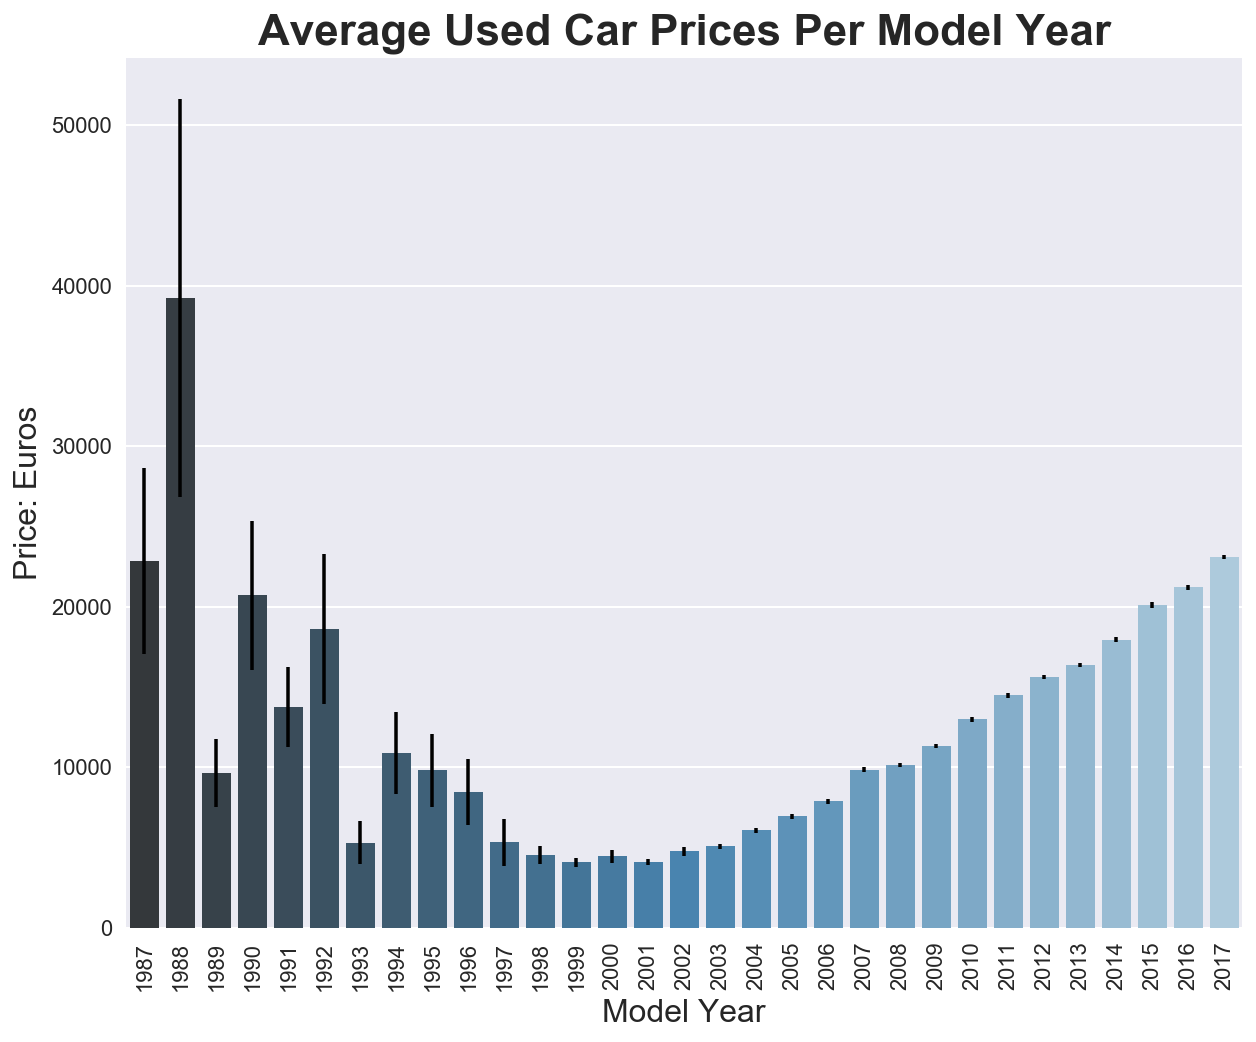

In [126]:
plt.figure(figsize=(10, 8));
sns.set_style("ticks", {"xtick.major.size": 16, "ytick.major.size":8});
sns.set(font_scale=1.1)
fig = sns.barplot(x=yearly_price['age'].astype(int),y= yearly_price['price'], yerr=sem_price['price'],capsize=4,errwidth=3,palette="Blues_d")
plt.ylabel('Price: Euros',fontsize=16);
plt.xlabel('Model Year',fontsize=16);
plt.xticks(rotation=90)
plt.title('Average Used Car Prices Per Model Year',fontsize=22,fontweight='bold');
#sns.savefig("Average Used Car Price Per Year.png")
plt.savefig('pricect.png', dpi=400)

Inspecting the counts in the age/year column for cars older than 1995

In [127]:
print(span_new[(span_new['age']<1995)].groupby('age')['ID'].count().reset_index())

      age  ID
0  1987.0  30
1  1988.0  23
2  1989.0  25
3  1990.0  39
4  1991.0  55
5  1992.0  64
6  1993.0  53
7  1994.0  62


#### What are the cars in 1988 that are making the barplot look like this ? 
- Looks like there are just a lot of expensive classics in 1988 and some very cheap cars (3250) which is why we see such a large spike with such a large error bar.

In [128]:
span_new[(span_new['age']== 1988)]

,Unnamed: 0,ID,make,model,months_old,power,gear_type,fuel_type,kms,price,age,Country
63,65,97799,Porsche,911,360.0,220.0,manual,gasoline,33000.0,195000,1988.0,Germany
64,66,97800,Porsche,911,360.0,220.0,manual,gasoline,30000.0,195000,1988.0,Germany
267,271,97798,Porsche,911,356.0,220.0,manual,gasoline,147000.0,119900,1988.0,Germany
293,298,97797,Porsche,911,356.0,169.0,manual,gasoline,215000.0,115000,1988.0,Germany
696,706,97796,Porsche,911,357.0,202.0,unknown,gasoline,169000.0,79000,1988.0,Germany
8580,8782,82814,Land,RoverRangeRover,350.0,93.0,manual,gasoline,54000.0,30000,1988.0,UK
12865,13178,82806,Land,RoverRangeRover,352.0,134.0,automatic,gasoline,98000.0,26000,1988.0,UK
28691,29447,82779,Land,RoverRangeRover,359.0,88.0,manual,diesel,147000.0,17900,1988.0,UK
29356,30125,14422,Bmw,320,354.0,95.0,automatic,gasoline,152000.0,17800,1988.0,Germany
39242,40338,16197,Bmw,325,359.0,125.0,automatic,gasoline,141000.0,14900,1988.0,Germany


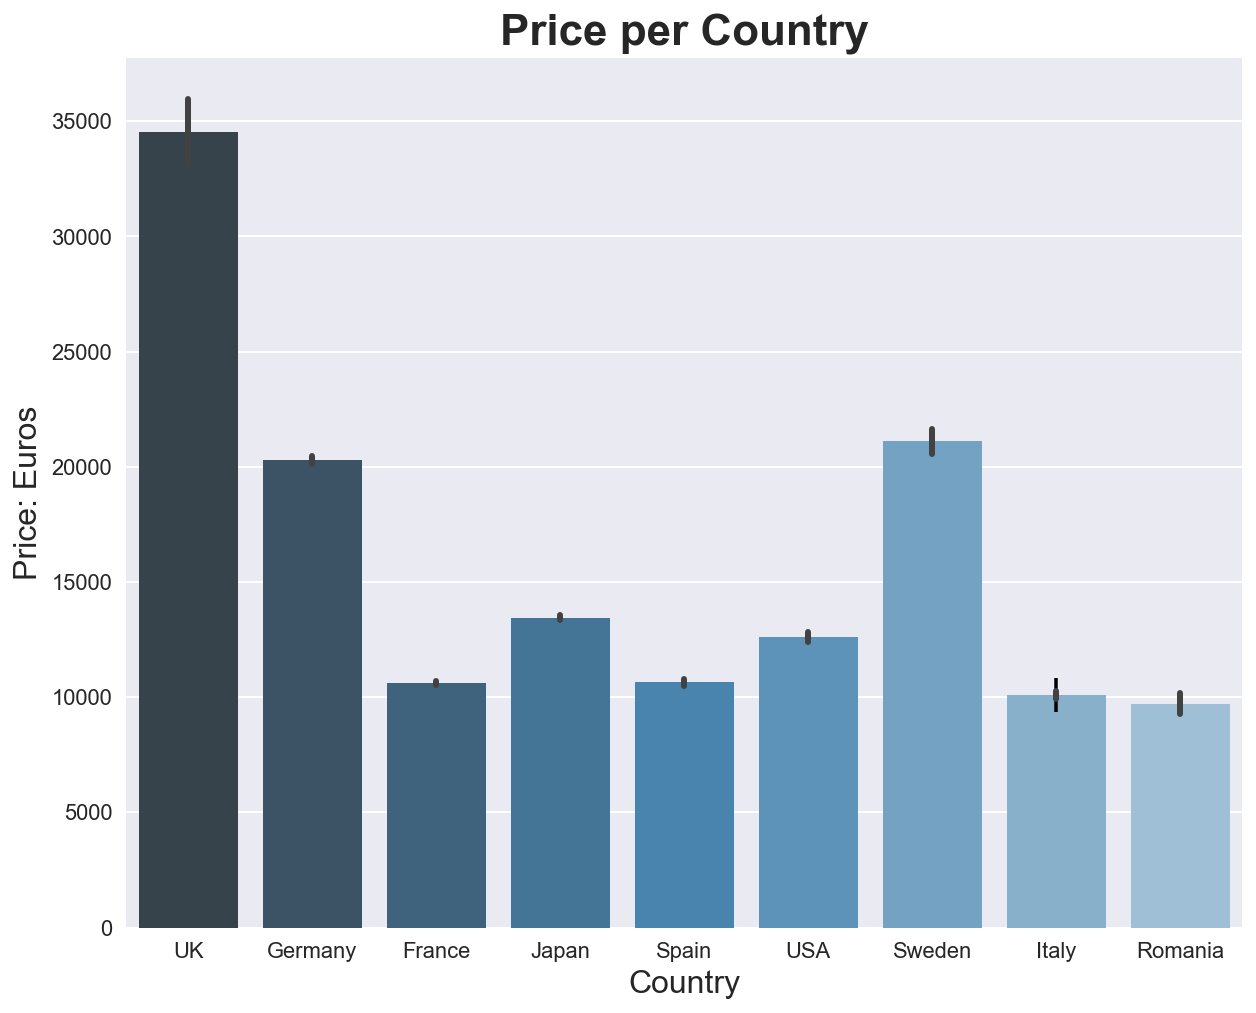

In [129]:
sem_price = span_new.groupby(['Country'])['price'].sem().reset_index()
plt.figure(figsize=(10, 8));
sns.set_style("ticks", {"xtick.major.size": 16, "ytick.major.size":8});
sns.set(font_scale=1.1)
fig = sns.barplot(x=span_new['Country'],y= span_new['price'],yerr=sem_price['price'],errwidth=3,palette="Blues_d")
plt.ylabel('Price: Euros',fontsize=16);
plt.xlabel('Country',fontsize=16);
plt.xticks()
plt.title('Price per Country',fontsize=22,fontweight='bold');

ANOVA

In [130]:
cprice = span_new[['Country','price']]
cprice_lm = ols('price ~ Country', data=cprice).fit()
print(anova_lm(cprice_lm))
df = multicomp.pairwise_tukeyhsd(cprice['price'], cprice['Country']).summary()
print(df)

               df        sum_sq       mean_sq            F  PR(>F)
Country       8.0  2.535372e+12  3.169215e+11  1665.718521     0.0
Residual  92370.0  1.757442e+13  1.902611e+08          NaN     NaN
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
 group1  group2   meandiff     lower       upper    reject
----------------------------------------------------------
 France Germany  9663.9669   9282.4806   10045.4532  True 
 France  Italy   -535.6725   -1342.7592   271.4141  False 
 France  Japan   2828.0487   2311.6108   3344.4866   True 
 France Romania  -906.9847   -3979.9327  2165.9633  False 
 France  Spain    18.8534    -671.8462    709.5531  False 
 France  Sweden  10472.868   9488.2863   11457.4497  True 
 France    UK    23924.0309  22963.5511  24884.5108  True 
 France   USA    1978.3526   1378.8544   2577.8509   True 
Germany  Italy  -10199.6394 -10967.7218  -9431.557   True 
Germany  Japan   -6835.9182  -7288.9853  -6382.8511  True 
Germany Romania -10570.9516 -136

###  Distribution of Mileage per Make -->  Are some cars driven more than others ?

   - Here, I compare the difference in distribution of mileage for different makes of cars in my dataset. I observe interesting things like Iveco with the most mileage covered in  distribution. This makes sense as Iveco is a Bus manufacturer ! 

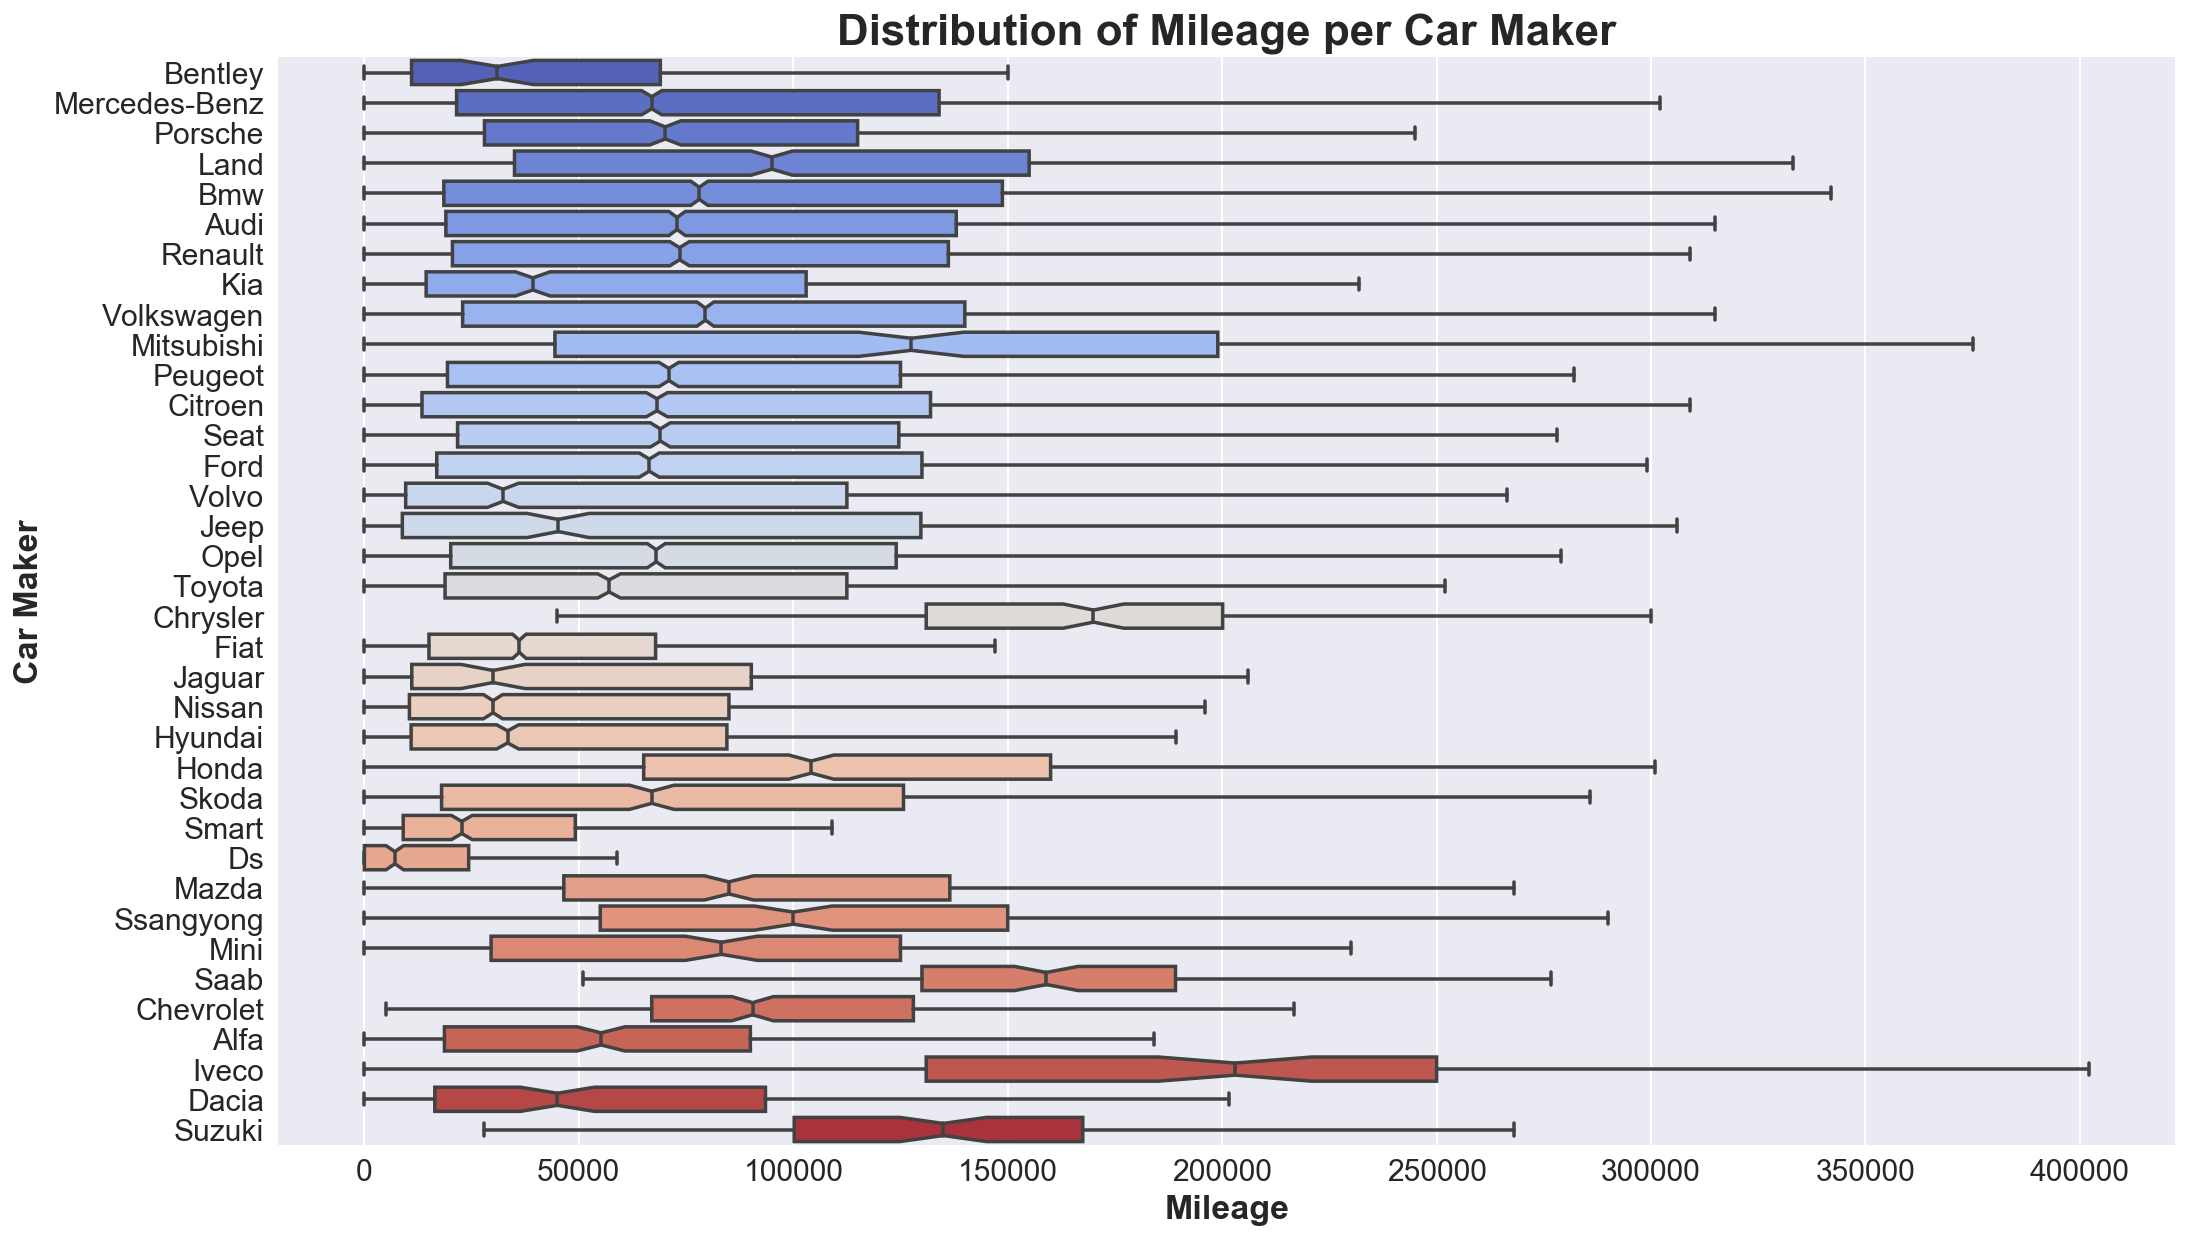

In [131]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(17, 10));
plot = sns.boxplot(x='kms',y='make',data=span_new,notch=True,orient='h',palette="coolwarm",showfliers=False)
plt.xlabel('Mileage',fontsize=17,fontweight="bold")
plt.ylabel('Car Maker',fontsize=17,fontweight="bold")
plt.title('Distribution of Mileage per Car Maker',fontsize=22,fontweight="bold")
plt.xlim()
plt.savefig('mileagect.png')
plt.show()


In [132]:
mprice = span_new[['make','kms']]
mprice_lm = ols('kms ~ make', data=mprice).fit()
print(anova_lm(mprice_lm))
tukey_mprice = multicomp.pairwise_tukeyhsd(mprice['kms'], mprice['make']).summary()
print(tukey_mprice)

               df        sum_sq       mean_sq           F  PR(>F)
make         35.0  2.141432e+13  6.118377e+11  112.678183     0.0
Residual  92343.0  5.014185e+14  5.429957e+09         NaN     NaN
            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
    group1        group2      meandiff      lower        upper     reject
-------------------------------------------------------------------------
     Alfa          Audi      29169.6544   14767.3184   43571.9905   True 
     Alfa        Bentley    -13223.1888  -42926.1568   16479.7792  False 
     Alfa          Bmw       33591.342    19222.1413   47960.5427   True 
     Alfa       Chevrolet    39423.4379   19312.9531   59533.9227   True 
     Alfa        Chrysler   113110.9853   89922.9775  136298.9931   True 
     Alfa        Citroen     23205.9552   8613.2626    37798.6477   True 
     Alfa         Dacia        92.547    -24541.2669   24726.3609  False 
     Alfa           Ds      -43189.1993  -63893.0014  -22485.3

In [133]:
tukey_df = pd.DataFrame(tukey_mprice.data,columns=['group1','group2','meandiff','lower','upper','reject'])
tukey_df[((tukey_df['group1']== 'Iveco') | (tukey_df['group2']== 'Iveco'))]

,group1,group2,meandiff,lower,upper,reject
13,Alfa,Iveco,136594,106058,167129,True
47,Audi,Iveco,107424,80183.3,134665,True
80,Bentley,Iveco,149817,112175,187459,True
112,Bmw,Iveco,103002,75779.1,130226,True
143,Chevrolet,Iveco,97170.4,66526.1,127815,True
173,Chrysler,Iveco,23482.8,-9263.49,56229.1,False
202,Citroen,Iveco,113388,86045.9,140730,True
230,Dacia,Iveco,136501,102716,170287,True
257,Ds,Iveco,179783,148746,210820,True
283,Fiat,Iveco,144318,116717,171918,True


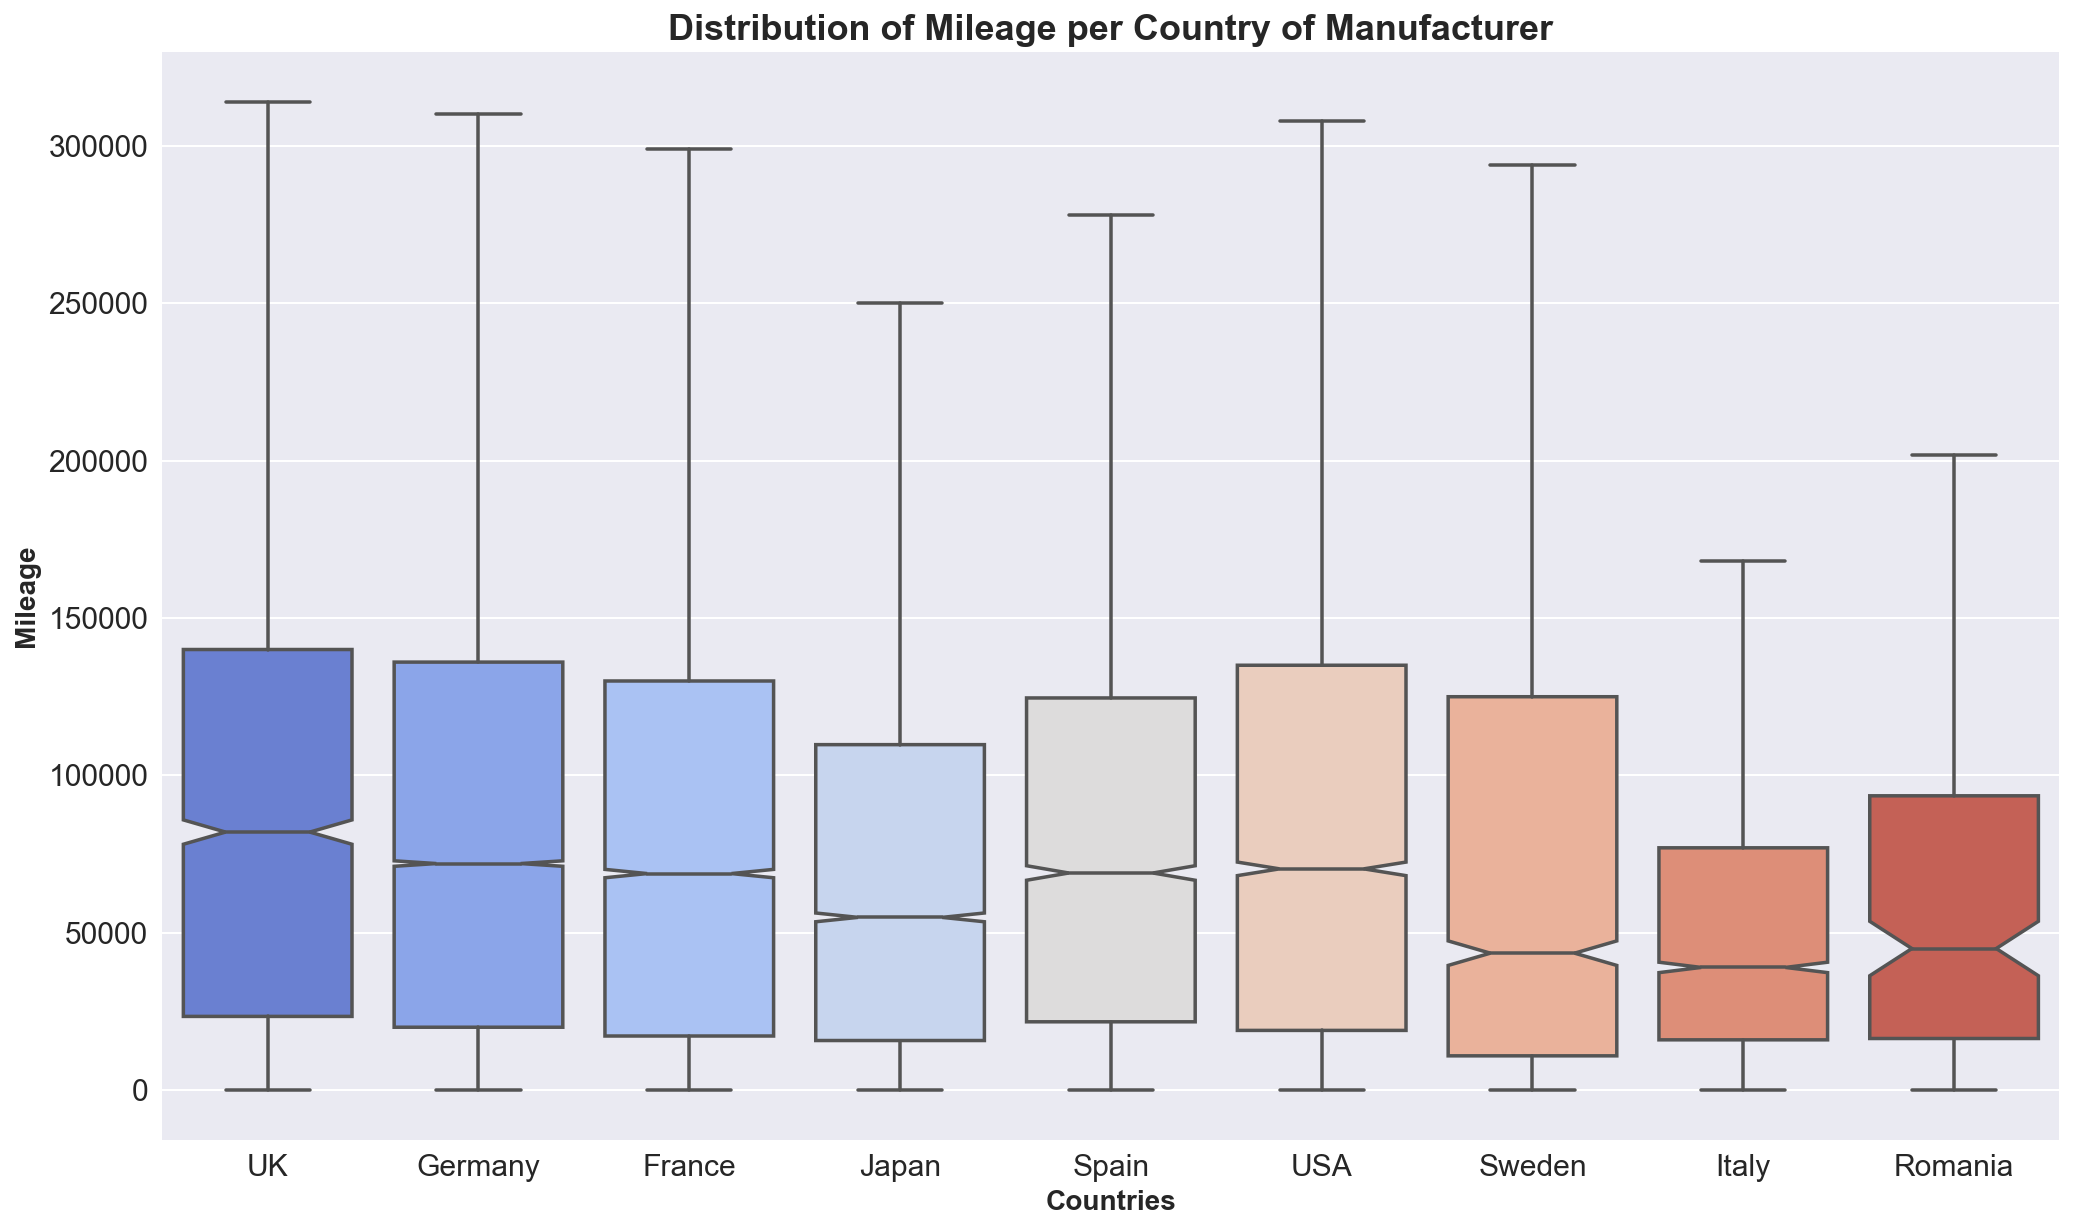

In [22]:
plt.figure(figsize=(17, 10));
sns.boxplot(x='Country',y='kms',data=span_new,notch=True,palette="coolwarm",showfliers=False)
plt.xlabel('Countries',fontsize=14,fontweight="bold")
plt.ylabel('Mileage',fontsize=14,fontweight="bold")
plt.title('Distribution of Mileage per Country of Manufacturer',fontsize=18,fontweight="bold")
plt.xlim()
plt.show()


#### ANOVA
Notes

In [23]:
cprice = span_new[['Country','kms']]
cprice_lm = ols('kms ~ Country', data=cprice).fit()
print(anova_lm(cprice_lm))
print(multicomp.pairwise_tukeyhsd(cprice['kms'], cprice['Country']).summary())

               df        sum_sq       mean_sq          F         PR(>F)
Country       8.0  5.125135e+12  6.406419e+11  114.30406  4.001573e-191
Residual  92370.0  5.177077e+14  5.604717e+09        NaN            NaN
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
 group1  group2   meandiff     lower       upper    reject
----------------------------------------------------------
 France Germany  5859.3688   3788.8428   7929.8949   True 
 France  Italy   -24956.669 -29337.1517 -20576.1864  True 
 France  Japan  -10006.8407  -12809.82   -7203.8613  True 
 France Romania -22777.9541 -39456.4546  -6099.4536  True 
 France  Spain   1691.8665   -2056.9227  5440.6558  False 
 France  Sweden  -7318.6372 -12662.4787  -1974.7957  True 
 France    UK    9471.2571    4258.229   14684.2853  True 
 France   USA     3642.595    388.8034   6896.3866   True 
Germany  Italy  -30816.0379  -34984.824 -26647.2518  True 
Germany  Japan  -15866.2095 -18325.2423 -13407.1766  True 
Germany Romania -

### What makes of cars have the highest horsepower ? Is the power associated with price ?
   - In terms of horsepower, we see a pretty reasonable effect in terms of distribution. Bentley ranks at #1, Porsche at #2, some Mercedes-Benz Cars at #3, and Land Rovers and Jaguars around #4.

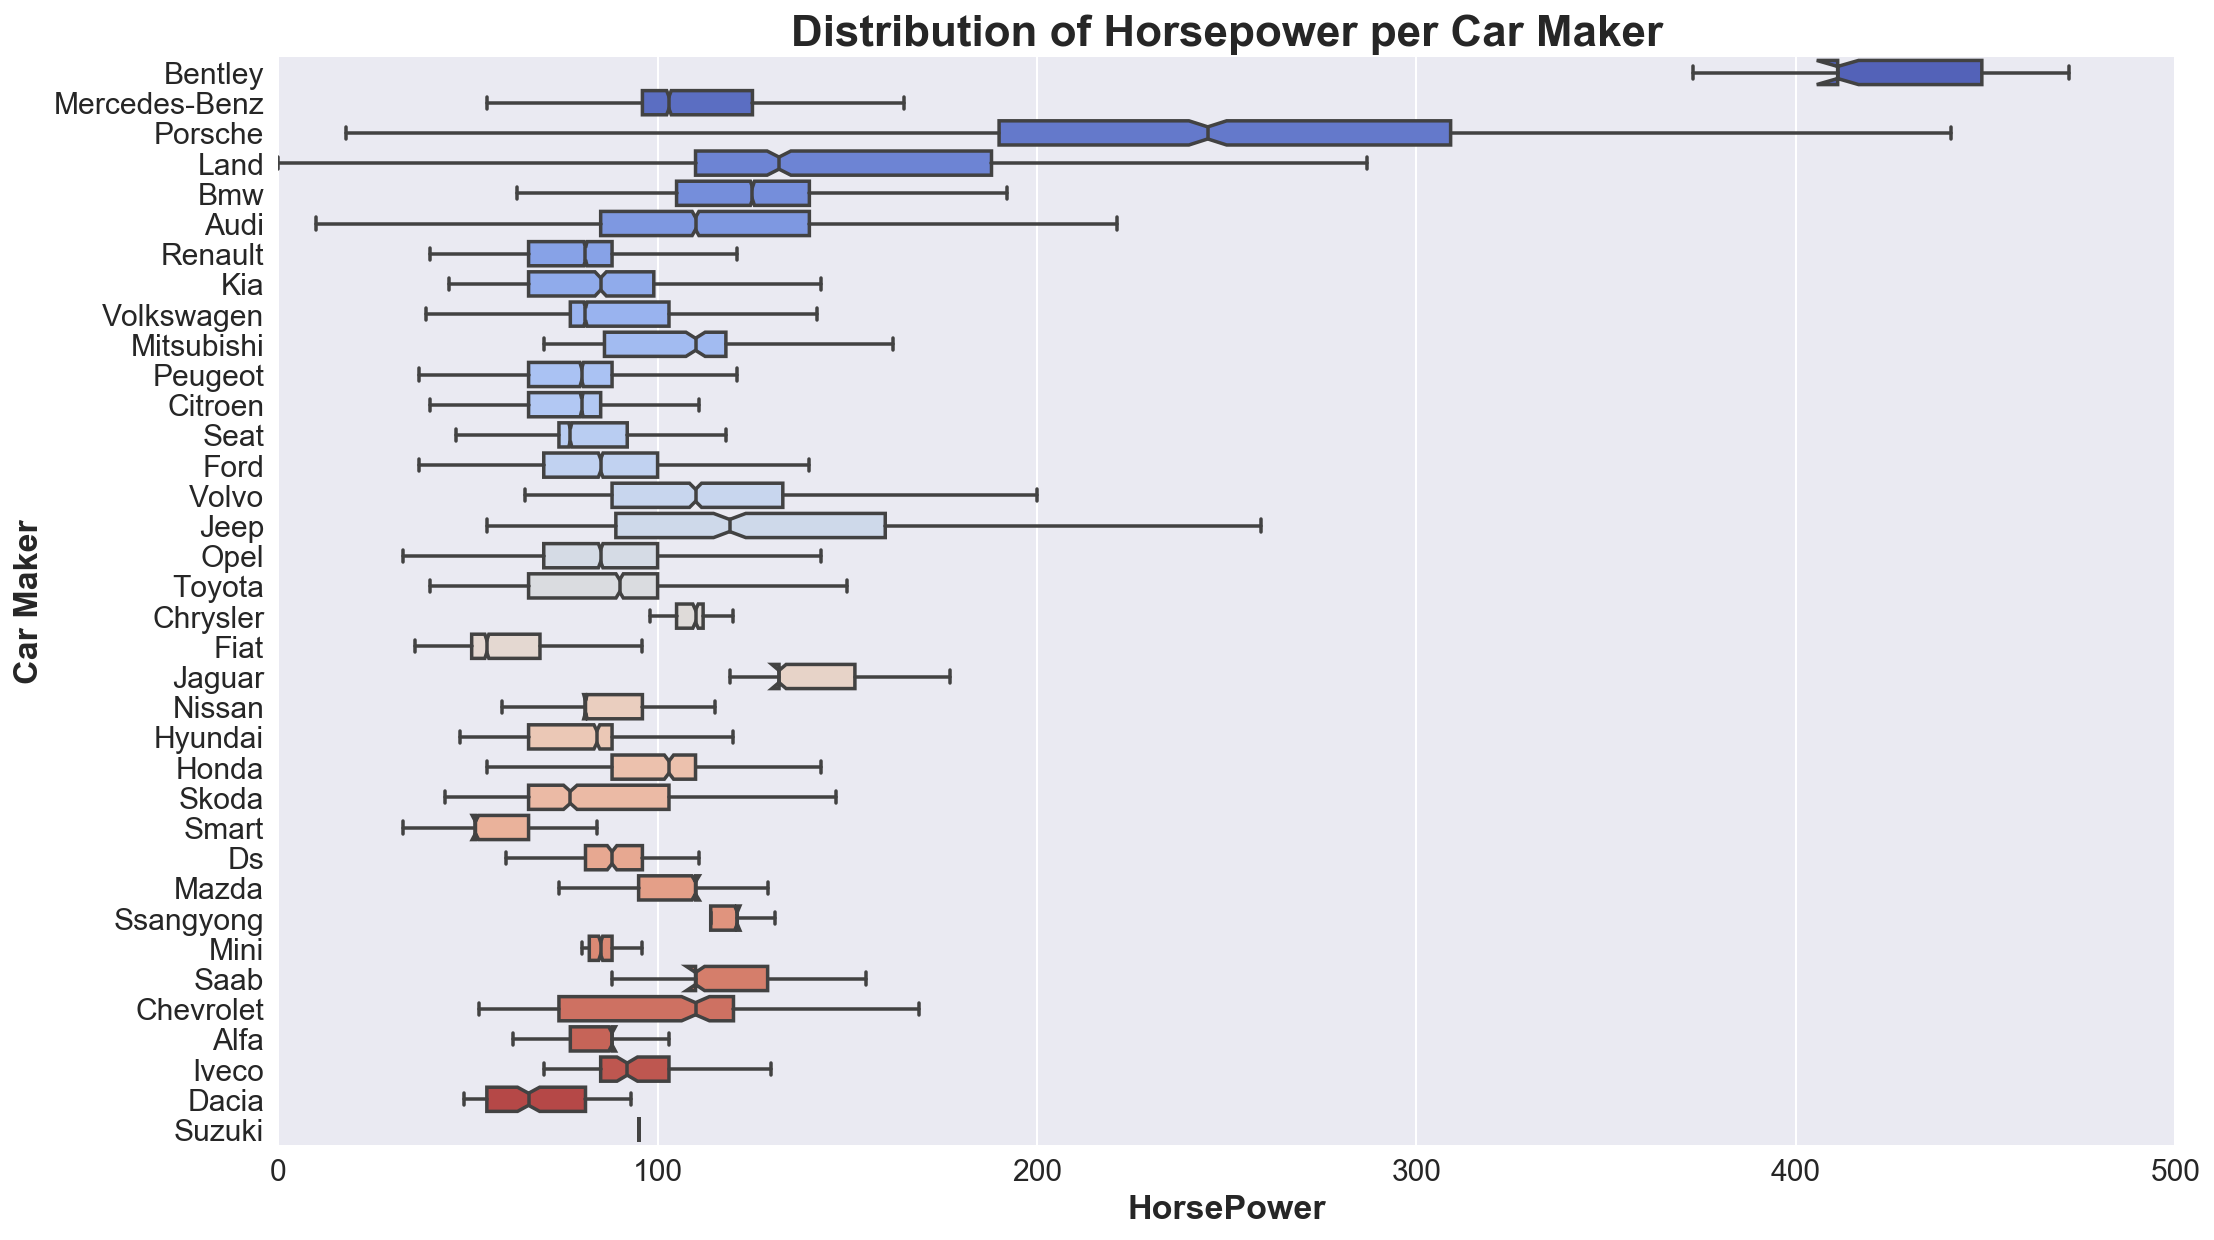

In [24]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(17, 10));
sns.boxplot(x='power',y='make',data=span_new,notch=True,orient='h',palette='coolwarm',showfliers=False)
plt.xlabel('HorsePower',fontsize=17,fontweight="bold")
plt.ylabel('Car Maker',fontsize=17,fontweight="bold")
plt.title('Distribution of Horsepower per Car Maker',fontsize=22,fontweight="bold")
plt.xlim(0,500)
plt.show()

#### Country Level Analysis of Horsepower

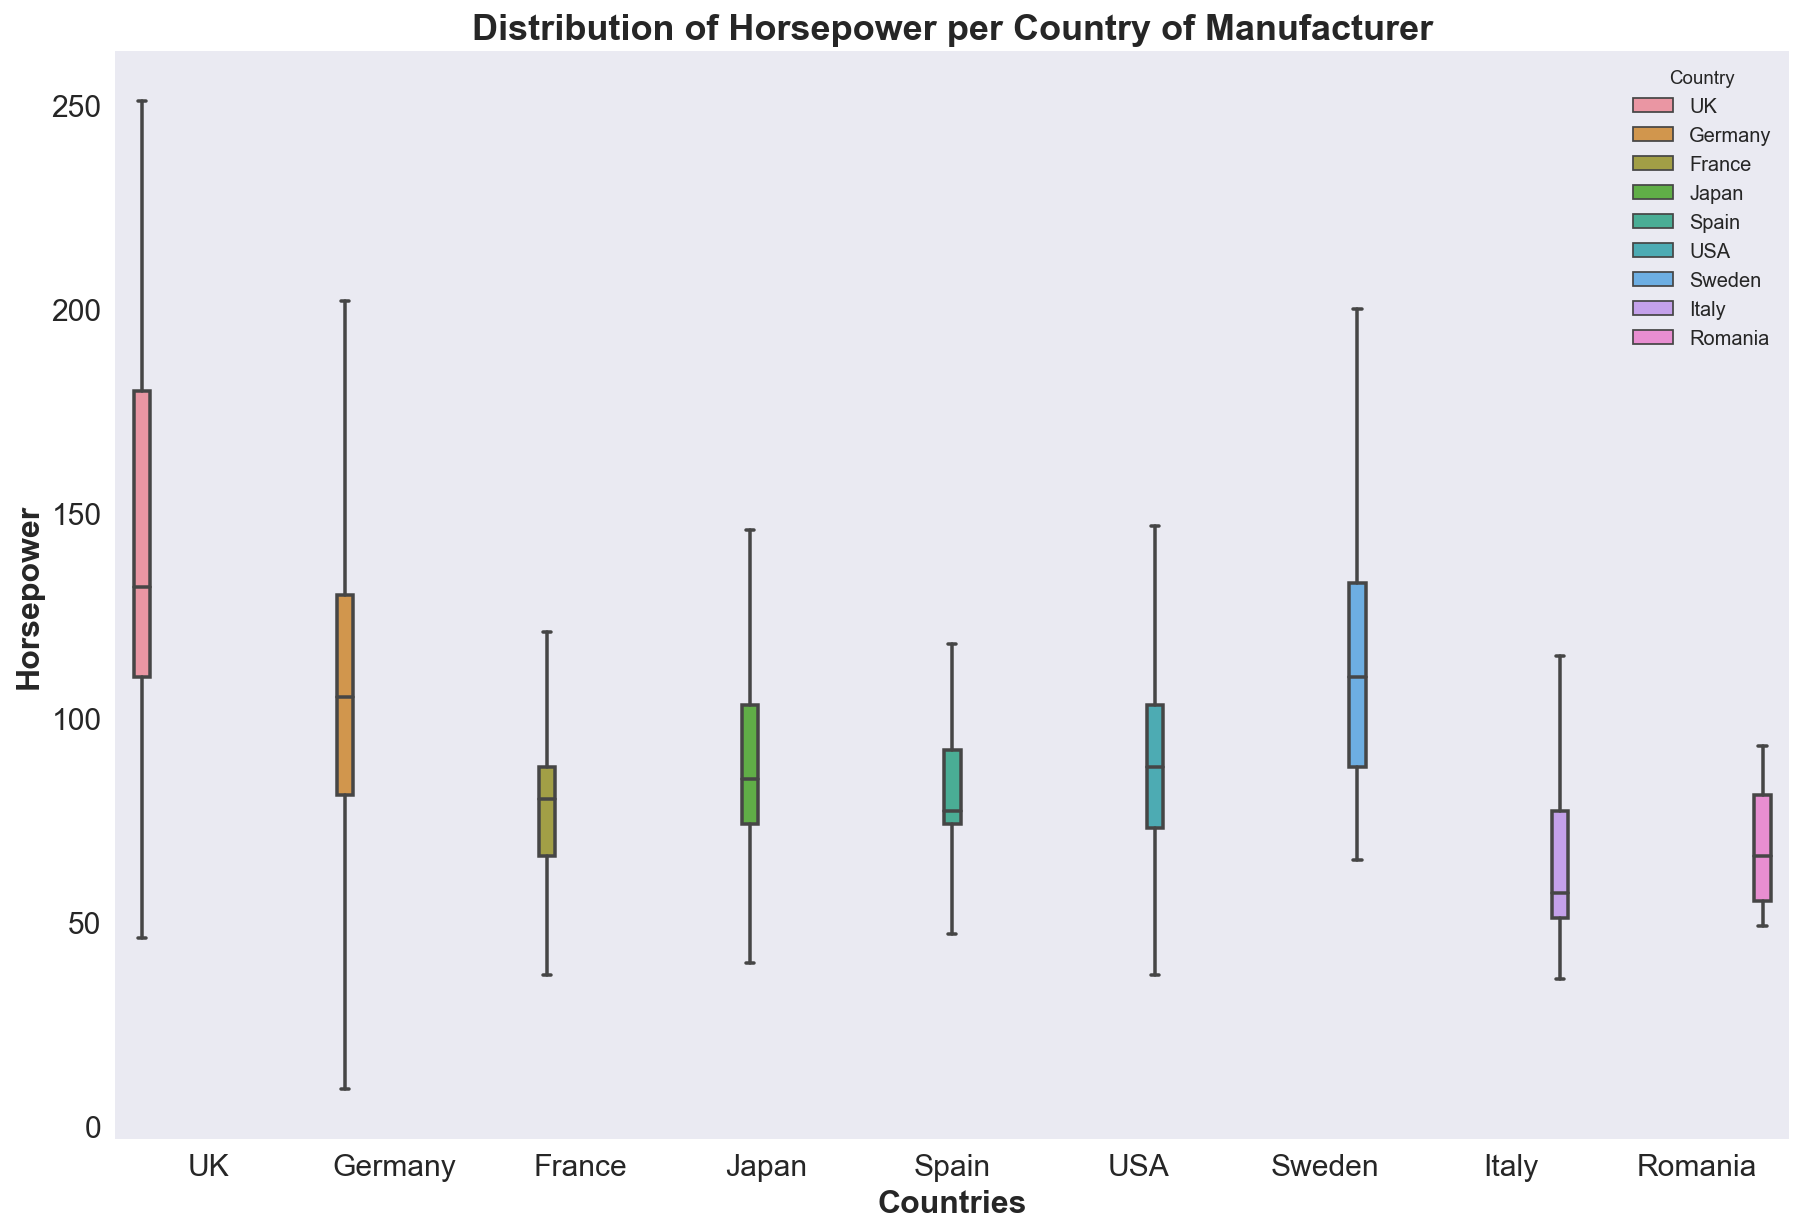

In [134]:
sns.set(style='dark')
plt.figure(figsize=(15, 10));
sns.boxplot(x='Country',y='power',data=span_new,showfliers=False,hue='Country')
plt.xlabel('Countries',fontsize=16,fontweight="bold")
plt.ylabel('Horsepower',fontsize=16,fontweight="bold")
plt.title('Distribution of Horsepower per Country of Manufacturer',fontsize=18,fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim()
plt.savefig('hpct.png',dpi=400)
plt.show()



In [135]:
pprice = span_new[['Country','power']]
pprice_lm = ols('power ~ Country', data=pprice).fit()
print(anova_lm(pprice_lm))
pt = multicomp.pairwise_tukeyhsd(pprice['power'], pprice['Country']).summary()

               df        sum_sq       mean_sq            F  PR(>F)
Country       8.0  2.952846e+07  3.691058e+06  2456.158803     0.0
Residual  92370.0  1.388115e+08  1.502776e+03          NaN     NaN


In [136]:
power_tukey = pd.DataFrame(pt.data,columns=['group1','group2','meandiff','lower','upper','reject'])
power_tukey[((power_tukey['group1']== 'UK') | (power_tukey['group2']== 'UK'))]

,group1,group2,meandiff,lower,upper,reject
7,France,UK,73.9291,71.2297,76.6284,True
14,Germany,UK,39.1,36.4921,41.7079,True
20,Italy,UK,86.7189,83.4331,90.0048,True
25,Japan,UK,63.3111,60.5257,66.0965,True
29,Romania,UK,83.3206,74.3631,92.2781,True
32,Spain,UK,69.2163,66.1471,72.2855,True
34,Sweden,UK,37.967,34.3189,41.6151,True
36,UK,USA,-57.8429,-60.7567,-54.929,True


### What cars are most frequent in the dataset? 


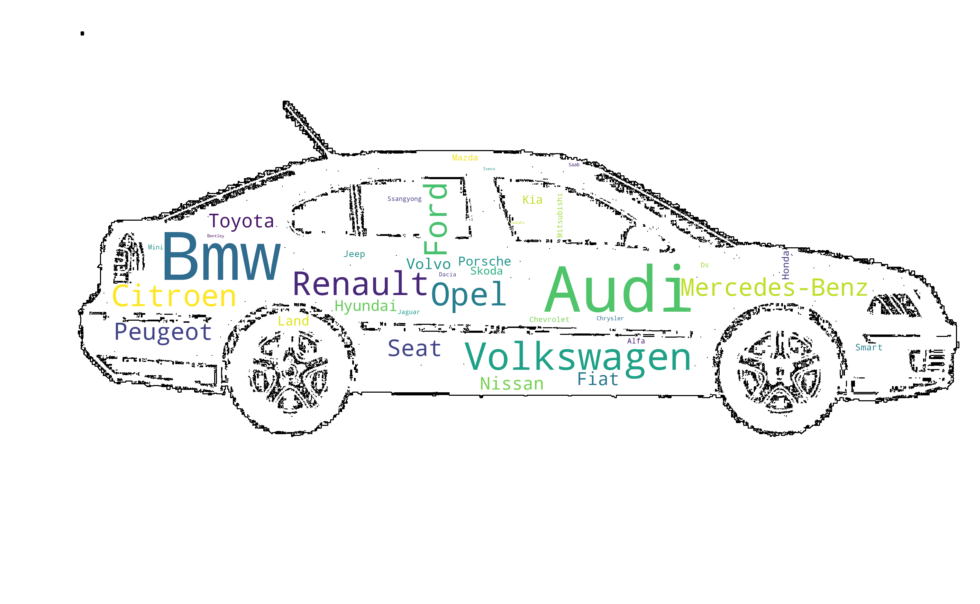

In [30]:
from PIL import Image
#Some fun Visualizations 
#Generate frequencies using counter
freqs = Counter(span_new['make'])
df = pd.DataFrame.from_dict(freqs, orient='index').reset_index()
df.columns = ['brands','freqs']
#Generate image
car_mask = np.array(Image.open('/Users/nadimyounes/Downloads/octavia.jpg'))
# Generate a word cloud with freqs
wc = WordCloud(background_color="white", max_words=1000, mask=car_mask,contour_width=2,contour_color='black')
wc.generate_from_frequencies(freqs)
plt.figure(figsize=(8, 8))
plt.axis("off")
make = span_new.groupby(['make'])['ID'].count().sort_values(ascending=False).reset_index()
plt.savefig('wordcloudcar.png')
plt.imshow(wc, interpolation='bilinear');


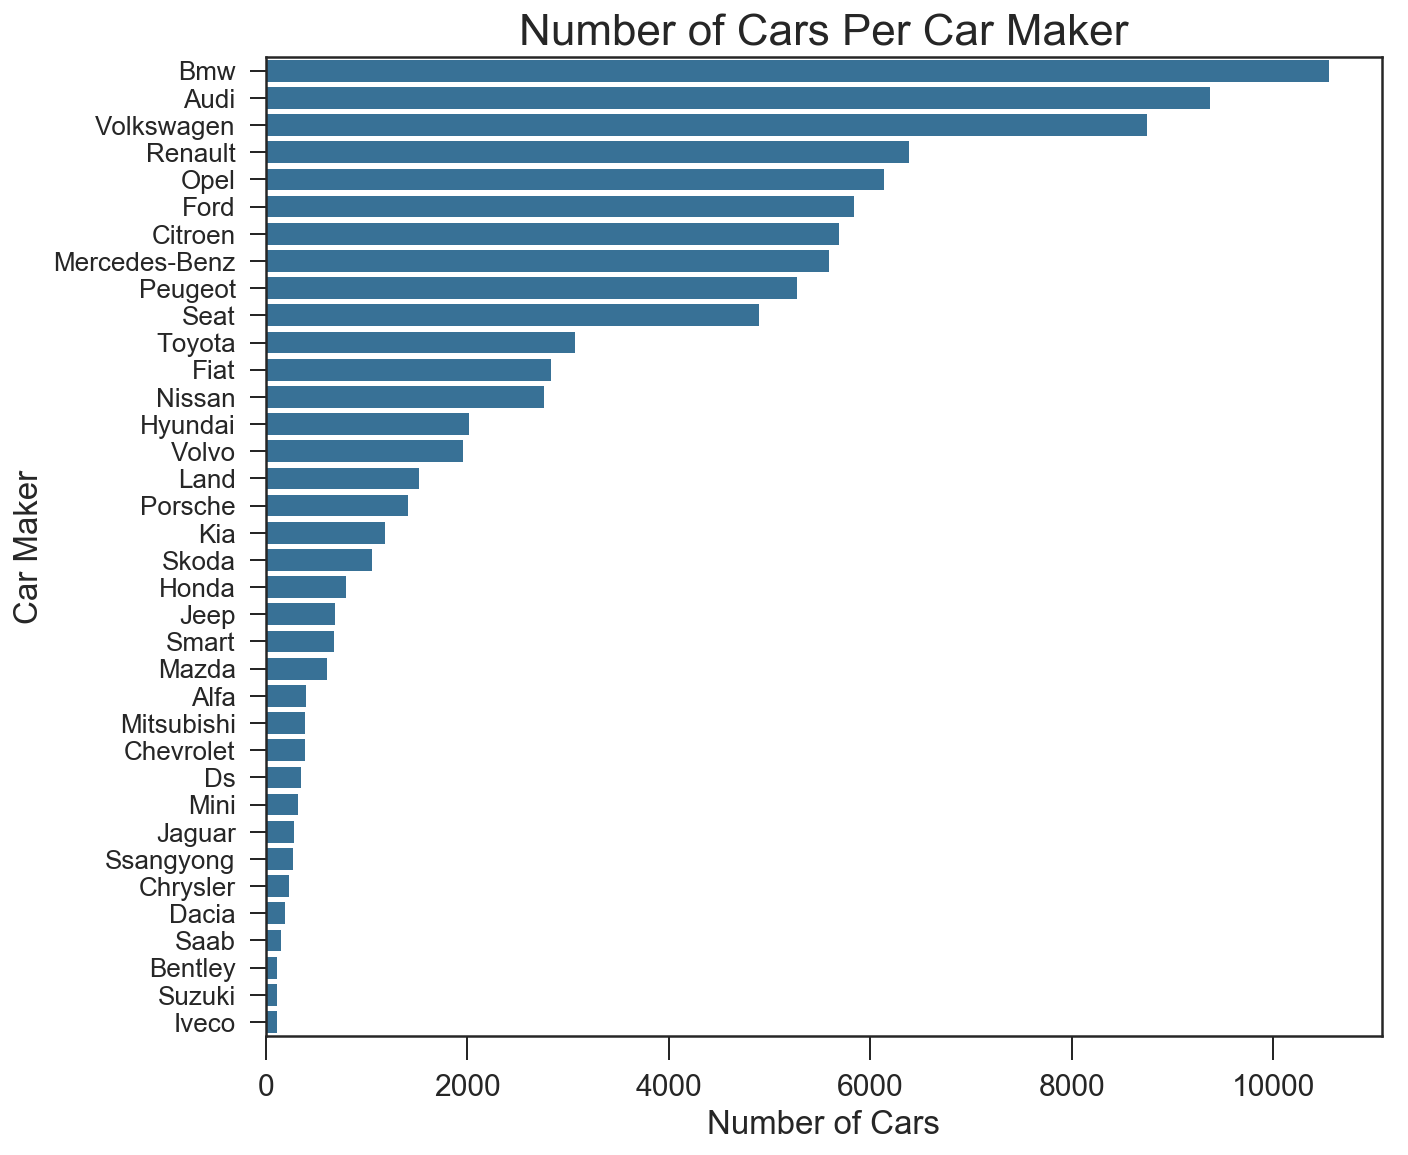

In [31]:
sns.set(font_scale = 1.25)
plt.figure(figsize=(10, 9));
sns.set_style("ticks",{"xtick.major.size": 12, "ytick.major.size":8})
make = span_new.groupby(['make'])['ID'].count().sort_values(ascending=False).reset_index();
sns.barplot(make['ID'],make['make'],orient='h',color="#2874A6");
plt.title("Number of Cars Per Car Maker",fontsize=22)
plt.ylabel('Car Maker',fontsize=16.5)
plt.xlabel('Number of Cars',fontsize=16.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.savefig('numberofcarzz.png')
plt.show()


#### Assessing the correlation coefficients of the numeric variables

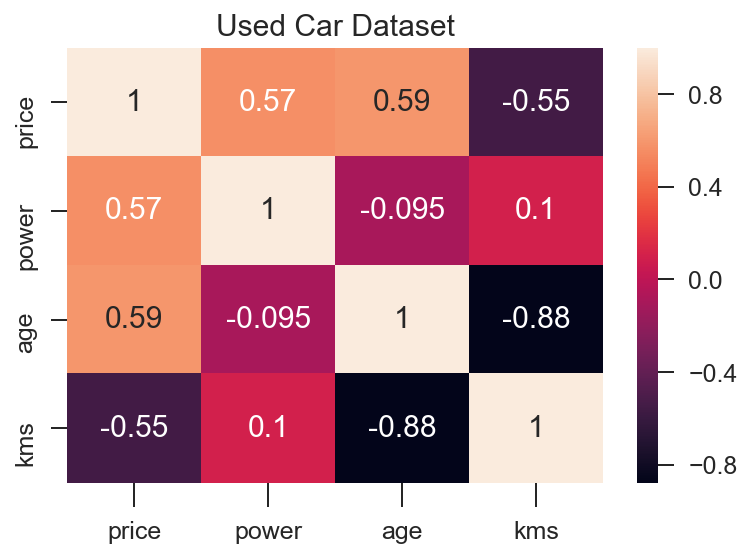

In [32]:
numeric_corr = span_new[['price','power','age','kms']].corr(method='spearman'); # non-parametric
sns.heatmap(numeric_corr,annot=True);
plt.title('Used Car Dataset');


<a id='ml' ></a>

## Part 4 - Machine Learning Models


- In this section, I test out 5 different regression models on my dataset. Please note that I don't do  K fold or any standard form of cross validation for the first 3 models as it would take a lot of time and processing power on my laptop.


- For the Decision tree Regressor and the KNN regressor, I just test out a range of values for the max_depth and number of neighbors and plot out the scores for the train/test values. I select the hyperparameter that don't result in overfitting and that return a good score on the test set. (small differences between training and testing sets  --> better at generalizing)  (essentially finding the right bias variance tradeoff)


- For the Xgboost and Random Forest Regressor, I optimized the hyperparameters using a randomized search cross validation and each took about one to two days to run. Note: the Xgboost was a lot slower to optimize hence why there are less parameters in the randomized search specific to the Xgboost regressor. Due to a lot of the heavy processing, I had to restart my kernel a couple times and didn't rerun the randomized search CVs but I saved the that the CV returned.


- Lastly, I just test out neural networks(Keras) as a proof of concept that simple networks can be used in predictive modelling for car valuation.


- Metrics: I use the R-Squared to determine which model I will use for deployment. I also use the Root Mean Squared error as it reflects the units of the outcome variable (price). 

In [102]:
span_X = span_new[['make','model','age','gear_type','fuel_type','power','kms','Country']]
le_features = span_new[['power','age','kms']]
# Dummy Categorical Variables 
span_X = pd.concat([span_X,pd.get_dummies(span_X['make'],drop_first=True,prefix="Make")],axis=1) 
span_X= pd.concat([span_X,pd.get_dummies(span_X['model'],drop_first=True,prefix="Model")],axis=1)
span_X = pd.concat([span_X,pd.get_dummies(span_X['gear_type'],drop_first=True,prefix="Gear")],axis=1)
span_X = pd.concat([span_X,pd.get_dummies(span_X['fuel_type'],drop_first=True,prefix="Fuel")],axis=1) 
span_X= pd.concat([span_X,pd.get_dummies(span_X['Country'],drop_first=True,prefix="Country")],axis=1)
# Remove Original Make, Model .. categorical variable columns 
features_final = span_X.drop(columns=['make','model','gear_type','fuel_type','Country']) 
# Subsetted out categorical variables in case I need to use them another time
cat = features_final.drop(columns=['kms','age','power'])


### Decision Tree Regressor

The first regression tree was just a proof of concept, to see which feature minimizes confusion for the tree most. (which feature is the most important in terms of mean squared impurity)

The Score on the test set with a basic decision tree regressor is: 0.653209896465
The Root Mean squared error with a basic decision tree regressor: 8309.84


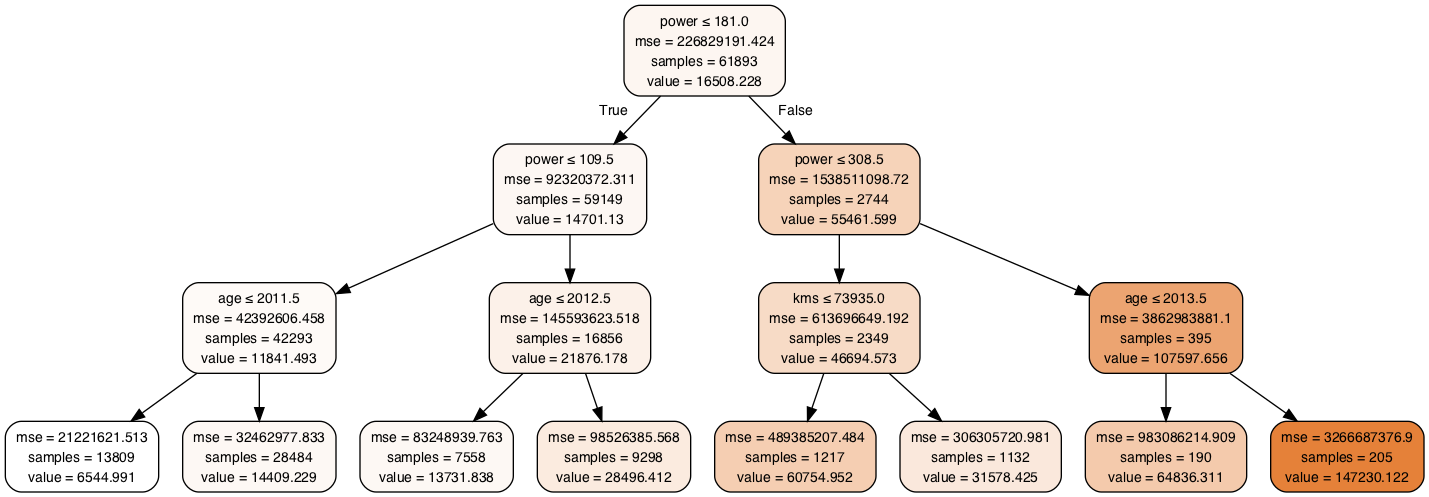

In [103]:
X_train, X_test, y_train, y_test = train_test_split(features_final, span_new['price'], test_size=0.33, random_state=42)
my_DT = tree.DecisionTreeRegressor(max_depth=3)
my_DT.fit(X_train, y_train)
y_pred_dt = my_DT.predict(X_test)
print('The Score on the test set with a basic decision tree regressor is:',my_DT.score(X_test,y_test))
print("The Root Mean squared error with a basic decision tree regressor: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred_dt)))

dot_data = StringIO()
export_graphviz(my_DT, out_file=dot_data,feature_names=features_final.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [46]:
trknn_scores=[]
teknn_scores= []
rmse_scores=[]
for i in np.arange(1,20,1):
    my_DT = tree.DecisionTreeRegressor(max_depth=i,random_state=42)
    my_DT.fit(X_train, y_train)
    y_pred_dt = my_DT.predict(X_test)
    train_scores = my_DT.score(X_train,y_train)
    test_scores = my_DT.score(X_test,y_test)
    # The Root mean squared error
    trknn_scores.append(train_scores)
    teknn_scores.append(test_scores)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_dt)))

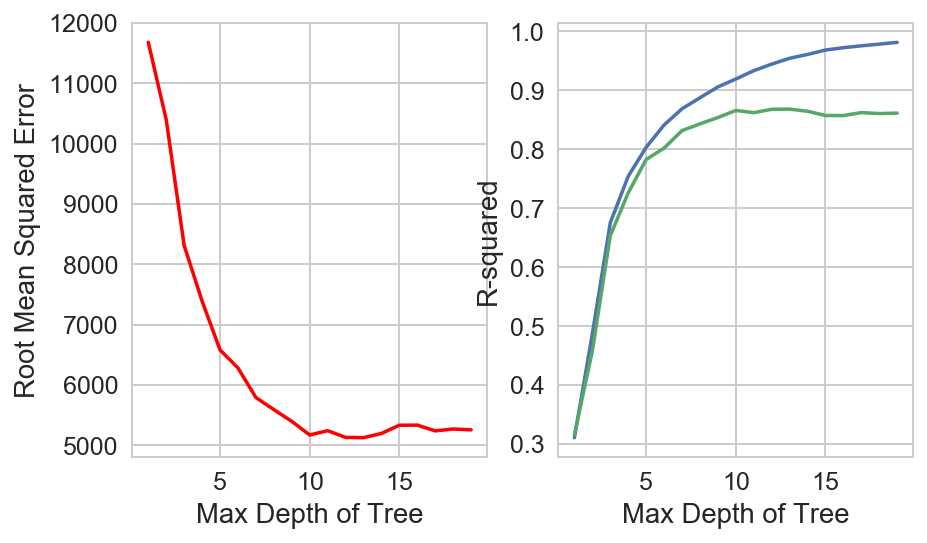

In [47]:
sns.set_style('whitegrid')
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(7,4));
ax1.plot(np.arange(1,20,1),rmse_scores,color='red');
ax2.plot(np.arange(1,20,1),trknn_scores);
ax2.plot(np.arange(1,20,1),teknn_scores);
ax1.set_xlabel('Max Depth of Tree')
ax2.set_xlabel('Max Depth of Tree')
ax1.set_ylabel('Root Mean Squared Error')
ax2.set_ylabel('R-squared');


In [104]:
from sklearn import tree
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(features_final, span_new['price'], test_size=0.33, random_state=42)
my_DT = tree.DecisionTreeRegressor(max_depth=8,random_state=42)
my_DT.fit(X_train, y_train)
y_pred_dt = my_DT.predict(X_test)
print('The Score on the training set with a decision tree regressor is:',my_DT.score(X_train,y_train))
print('The Score on the test set with a decision tree regressor is:',my_DT.score(X_test,y_test))
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred_dt)))

The Score on the training set with a decision tree regressor is: 0.887305860125
The Score on the test set with a decision tree regressor is: 0.843046342294
Mean squared error: 5590.43


### Linear Regression Model

In [96]:
# Linear Regression Sklearn 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
lreg = LinearRegression()
lreg.fit(X_train,y_train)
y_pred_linear = lreg.predict(X_test)
print('The Score on the test set with a linear regression is:', lreg.score(X_test,y_test))
# The Root mean squared error
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred_linear)))


The Score on the test set with a linear regression is: 0.764612040444
Mean squared error: 6846.23


### KNN Regressor

In [106]:
KNR = KNeighborsRegressor()


trknn_scores=[]
teknn_scores= []
rmse_scores=[]

for i in np.arange(1,100,5):
    KNR = KNeighborsRegressor(n_neighbors=i)
    KNR.fit(X_train,y_train)
    KNR.score(X_test,y_test)
    train_scores = KNR.score(X_train,y_train)
    test_scores = KNR.score(X_test,y_test)
    # The Root mean squared error
    trknn_scores.append(train_scores)
    teknn_scores.append(test_scores)
    y_pred_knn = KNR.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_knn)))

Text(0,0.5,'R-squared')

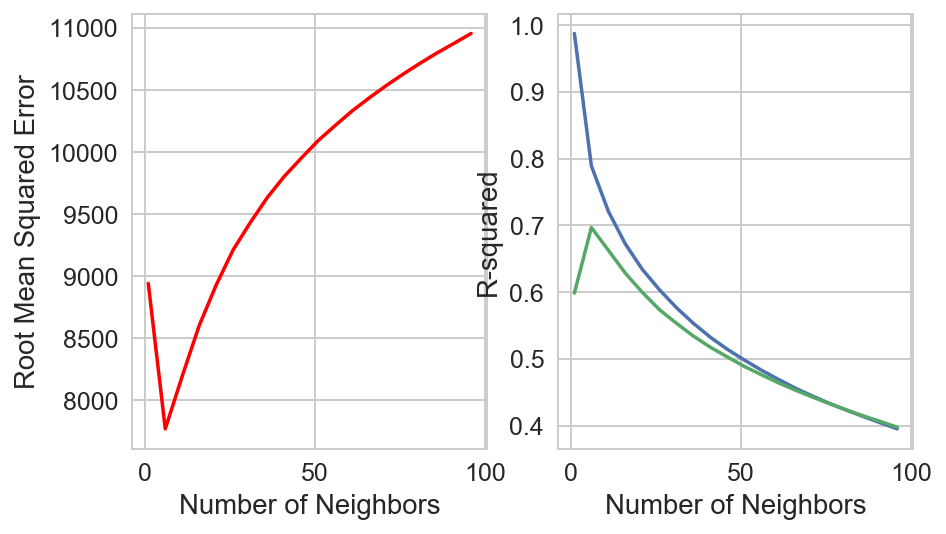

In [110]:
sns.set_style('whitegrid')
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(7,4))
ax1.plot(np.arange(1,100,5),rmse_scores,color='red')
ax2.plot(np.arange(1,100,5),trknn_scores)
ax2.plot(np.arange(1,100,5),teknn_scores)
ax1.set_xlabel('Number of Neighbors')
ax2.set_xlabel('Number of Neighbors')
ax1.set_ylabel('Root Mean Squared Error')
ax2.set_ylabel('R-squared')

In [142]:
KNR = KNeighborsRegressor(n_neighbors=6)
KNR.fit(X_train,y_train)
y_pred_KNR = KNR.predict(X_test)
print('The Score on the test set with a KNN regressor is:',KNR.score(X_test,y_test))
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred_KNR)))

The Score on the test set with a KNN regressor is: 0.696655440949
Mean squared error: 7771.91


### Random Forest Regressor 

In [63]:
#Random Forest Regressor 
from sklearn.ensemble import RandomForestRegressor
rand_est = RandomForestRegressor()
rand_est.fit(X_train,y_train)
y_pred = rand_est.predict(X_test)
print(' The Score on the test set with a random forest regressor is:', rand_est.score(X_test,y_test))
#pretty good score dude 
# The Root mean squared error
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))

 The Score on the test set with a random forest regressor is: 0.89315387292
Mean squared error: 4612.53


I tried to optimized the RFR previously and I got the paremeters I printed below

In [ ]:
RFR = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = RFR, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [69]:
print('These are the best parameters from the randomized search:{max_depth: 40, n_estimators: 600, min_samples_split: 10, min_samples_leaf: 1, bootstrap: False, max_features: sqrt}')

These are the best parameters from the randomized search:{max_depth: 40, n_estimators: 600, min_samples_split: 10, min_samples_leaf: 1, bootstrap: False, max_features: sqrt}


In [72]:
#Try out hyperparameters that were optimized before 
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(features_final, span_new['price'], test_size=0.33, random_state=42)
rand_est = RandomForestRegressor(max_depth=40, n_estimators= 600, min_samples_split= 10, min_samples_leaf= 1, bootstrap= False, max_features= 'sqrt')
rand_est.fit(X_train,y_train)
y_pred_rfr = rand_est.predict(X_test)
print(' The Score on the train set with a hyperparameter optimized random forest regressor is:',rand_est.score(X_train,y_train))
print(' The Score on the test set with a hyperparameter optimized random forest regressor is:',rand_est.score(X_test,y_test))
print("Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred_rfr)))

 The Score on the train set with a hyperparameter optimized random forest regressor is: 0.963858505802
 The Score on the test set with a hyperparameter optimized random forest regressor is: 0.931161144818
Mean squared error: 3702.34


In [137]:
feature_importances = pd.DataFrame(rand_est.feature_importances_)
print(feature_importances.sort_values(by=0,ascending=False).head(10))


            0
1    0.245039
0    0.127988
2    0.127449
284  0.073689
27   0.068313
71   0.050348
4    0.033366
133  0.029948
292  0.018551
201  0.014498


#### Analyzing Feature Importances for highest scoring model

In [140]:
pd.Series(x).reset_index()[0]

0                power
1                  age
2                  kms
3          Gear_manual
4         Make_Porsche
5            Model_911
6         Make_Bentley
7    Model_Continental
8      Country_Germany
9       Model_Panamera
Name: 0, dtype: object

In [773]:
for i in feature_importances.sort_values(by=0,ascending=False).tail(5).index:
    print(features_final.columns[i])
    

Model_RomeoMito
Model_CooperD
Model_GrandVitara
Make_Suzuki
Model_Duster


### XgBoost Regressor 

In [66]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
xgbr = XGBRegressor()
xgbr.fit(X_train,y_train)
y_pred_xgbr = xgbr.predict(X_test)
print(xgbr)
print('The Score on the test set with an XGboost Regressor is:',xgbr.score(X_test,y_test))
print("Mean squared error: %.2f", np.sqrt(mean_squared_error(y_test,y_pred_xgbr)))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The Score on the test set with an XGboost Regressor is: 0.88998969507
Mean squared error: %.2f 4680.32698922


In [ ]:
#Let's Optimize the XGBOOST - Run this overnight (I did this and it failed to return scores higher than the score above) )
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
xgbr = XGBRegressor()

max_depth = [3,5,10]
n_estimators = [500,600,800]
learning_rate = [0.15,0.3]
params = {
    #Hypeparameter tuning 
    'max_depth':max_depth,
    'n_estimators':n_estimators,
    'learning_rate':learning_rate}
xgbr_random = RandomizedSearchCV(estimator = xgbr, param_distributions = params, n_iter = 4, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgbr_random.fit(X_train, y_train)

In [74]:
print('These are the best parameters from the randomized search (Xgboost) :{max_depth: 5, n_estimators: 500, min_samples_split: 10, learning_rate=0.2}')

These are the best parameters from the randomized search (Xgboost) :{max_depth: 5, n_estimators: 500, min_samples_split: 10, learning_rate=0.2}


In [68]:
# Using the best parameters from randomized search
xgbr = XGBRegressor(learning_rate= 0.2, max_depth= 5, n_estimators= 500)
xgbr.fit(X_train,y_train)
y_pred = xgbr.predict(X_test)
print(xgbr)
print('The Score on the test set with an XGboost Regressor is:',xgbr.score(X_test,y_test))
print("Mean squared error: %.2f", np.sqrt(mean_squared_error(y_test,y_pred)))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
The Score on the test set with an XGboost Regressor is: 0.920418030953
Mean squared error: %.2f 3980.76785677


## Neural Networks 

In [887]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# create model
opt = optimizers.Adam(lr=0.001,epsilon=10**-8)
model = Sequential()
model.add(Dense(256, input_dim=292, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, input_dim=292, kernel_initializer='normal', activation='relu'))
# Initializations define the way to set the initial random weights of Keras layers.
model.add(Dense(1, kernel_initializer='normal')) #
# Compile model
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[coeff_determination]) #  configure the learning process, which is done via the compile method.
#estimator = KerasRegressor(build_fn=keras_model, epochs=100, batch_size=35, verbose=1)
model.fit(X_train.values,y_train.values,epochs=100, batch_size=64, verbose=1)

Epoch 1/100
61897/61897 [==============================] - 7s 106us/step - loss: 214056762.5852 - coeff_determination: 0.1972
Epoch 2/100
61897/61897 [==============================] - 6s 99us/step - loss: 121384327.8275 - coeff_determination: 0.5188
Epoch 3/100
61897/61897 [==============================] - 6s 100us/step - loss: 84914829.2404 - coeff_determination: 0.6956
Epoch 4/100
61897/61897 [==============================] - 6s 99us/step - loss: 82095846.0363 - coeff_determination: 0.7113
Epoch 5/100
61897/61897 [==============================] - 7s 108us/step - loss: 82533370.3020 - coeff_determination: 0.7030
Epoch 6/100
61897/61897 [==============================] - 6s 104us/step - loss: 80304771.0107 - coeff_determination: 0.7201
Epoch 7/100
61897/61897 [==============================] - 6s 93us/step - loss: 88871645.1395 - coeff_determination: 0.6551
Epoch 8/100
61897/61897 [==============================] - 6s 95us/step - loss: 79430708.3035 - coeff_determination: 0.7215
Ep

In [62]:
# Create Model
opt = optimizers.Nadam()
model = Sequential()
model.add(Dense(256, input_dim=300, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, input_dim=300, kernel_initializer='normal', activation='relu'))
# Initializations define the way to set the initial random weights of Keras layers.
model.add(Dense(1, kernel_initializer='normal')) #
# Compile model
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[coeff_determination]) #  configure the learning process, which is done via the compile method.
#estimator = KerasRegressor(build_fn=keras_model, epochs=100, batch_size=35, verbose=1)
model.fit(X_train.values,y_train.values,epochs=100, batch_size=64, verbose=1)

Epoch 1/100
61893/61893 [==============================] - 6s 99us/step - loss: 165157641.6792 - coeff_determination: 0.2087
Epoch 2/100
61893/61893 [==============================] - 6s 94us/step - loss: 81373135.4357 - coeff_determination: 0.5589
Epoch 3/100
61893/61893 [==============================] - 6s 90us/step - loss: 66069129.3447 - coeff_determination: 0.6446
Epoch 4/100
61893/61893 [==============================] - 6s 95us/step - loss: 63279384.7791 - coeff_determination: 0.6770
Epoch 5/100
61893/61893 [==============================] - 6s 97us/step - loss: 58878235.0728 - coeff_determination: 0.6914
Epoch 6/100
61893/61893 [==============================] - 6s 98us/step - loss: 54803535.7687 - coeff_determination: 0.7224
Epoch 7/100
61893/61893 [==============================] - 6s 97us/step - loss: 51183369.5269 - coeff_determination: 0.7433
Epoch 8/100
61893/61893 [==============================] - 6s 104us/step - loss: 51455604.7957 - coeff_determination: 0.7453
Epoch 

61893/61893 [==============================] - 6s 91us/step - loss: 35376734.9342 - coeff_determination: 0.8385
Epoch 67/100
61893/61893 [==============================] - 6s 101us/step - loss: 34686555.2026 - coeff_determination: 0.8435
Epoch 68/100
61893/61893 [==============================] - 7s 112us/step - loss: 34994379.4826 - coeff_determination: 0.8418
Epoch 69/100
61893/61893 [==============================] - 6s 99us/step - loss: 34990242.6441 - coeff_determination: 0.8406
Epoch 70/100
61893/61893 [==============================] - 6s 90us/step - loss: 34960737.5843 - coeff_determination: 0.8400
Epoch 71/100
61893/61893 [==============================] - 5s 87us/step - loss: 34552402.3333 - coeff_determination: 0.8437
Epoch 72/100
61893/61893 [==============================] - 6s 95us/step - loss: 34686141.1055 - coeff_determination: 0.8401
Epoch 73/100
61893/61893 [==============================] - 5s 77us/step - loss: 34597118.8139 - coeff_determination: 0.8396
Epoch 74/10

In [149]:
# Create Model
opt = optimizers.Nadam()
model = Sequential()
model.add(Dense(512, input_dim=300, kernel_initializer='normal', activation='relu'))
model.add(Dense(512, input_dim=300, kernel_initializer='normal', activation='relu'))
# Initializations define the way to set the initial random weights of Keras layers.
model.add(Dense(1, kernel_initializer='normal')) #
# Compile model
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[coeff_determination]) #  configure the learning process, which is done via the compile method.
#estimator = KerasRegressor(build_fn=keras_model, epochs=100, batch_size=35, verbose=1)
model.fit(X_train.values,y_train.values,epochs=100, batch_size=32, verbose=1)

Epoch 1/100
61893/61893 [==============================] - 18s 298us/step - loss: 140148541.1405 - coeff_determination: 0.2182
Epoch 2/100
61893/61893 [==============================] - 20s 316us/step - loss: 76959374.0232 - coeff_determination: 0.5441
Epoch 3/100
61893/61893 [==============================] - 15s 239us/step - loss: 62487532.6419 - coeff_determination: 0.6385
Epoch 4/100
61893/61893 [==============================] - 13s 214us/step - loss: 53792768.5240 - coeff_determination: 0.7023
Epoch 5/100
61893/61893 [==============================] - 16s 255us/step - loss: 51613347.4408 - coeff_determination: 0.7133
Epoch 6/100
61893/61893 [==============================] - 17s 283us/step - loss: 49531076.5296 - coeff_determination: 0.7309
Epoch 7/100
61893/61893 [==============================] - 16s 258us/step - loss: 48705095.1272 - coeff_determination: 0.7407
Epoch 8/100
61893/61893 [==============================] - 16s 254us/step - loss: 47607993.7861 - coeff_determination

61893/61893 [==============================] - 15s 239us/step - loss: 35151132.7813 - coeff_determination: 0.8280
Epoch 66/100
61893/61893 [==============================] - 15s 249us/step - loss: 34960469.3159 - coeff_determination: 0.8269
Epoch 67/100
61893/61893 [==============================] - 18s 286us/step - loss: 34675870.4740 - coeff_determination: 0.8317
Epoch 68/100
61893/61893 [==============================] - 18s 292us/step - loss: 34919643.0871 - coeff_determination: 0.8302
Epoch 69/100
61893/61893 [==============================] - 18s 292us/step - loss: 34823083.4777 - coeff_determination: 0.8313
Epoch 70/100
61893/61893 [==============================] - 16s 255us/step - loss: 34603035.9222 - coeff_determination: 0.8317
Epoch 71/100
61893/61893 [==============================] - 16s 259us/step - loss: 34377987.4995 - coeff_determination: 0.8298
Epoch 72/100
61893/61893 [==============================] - 18s 286us/step - loss: 34827444.8991 - coeff_determination: 0.83

### Model Comparisons

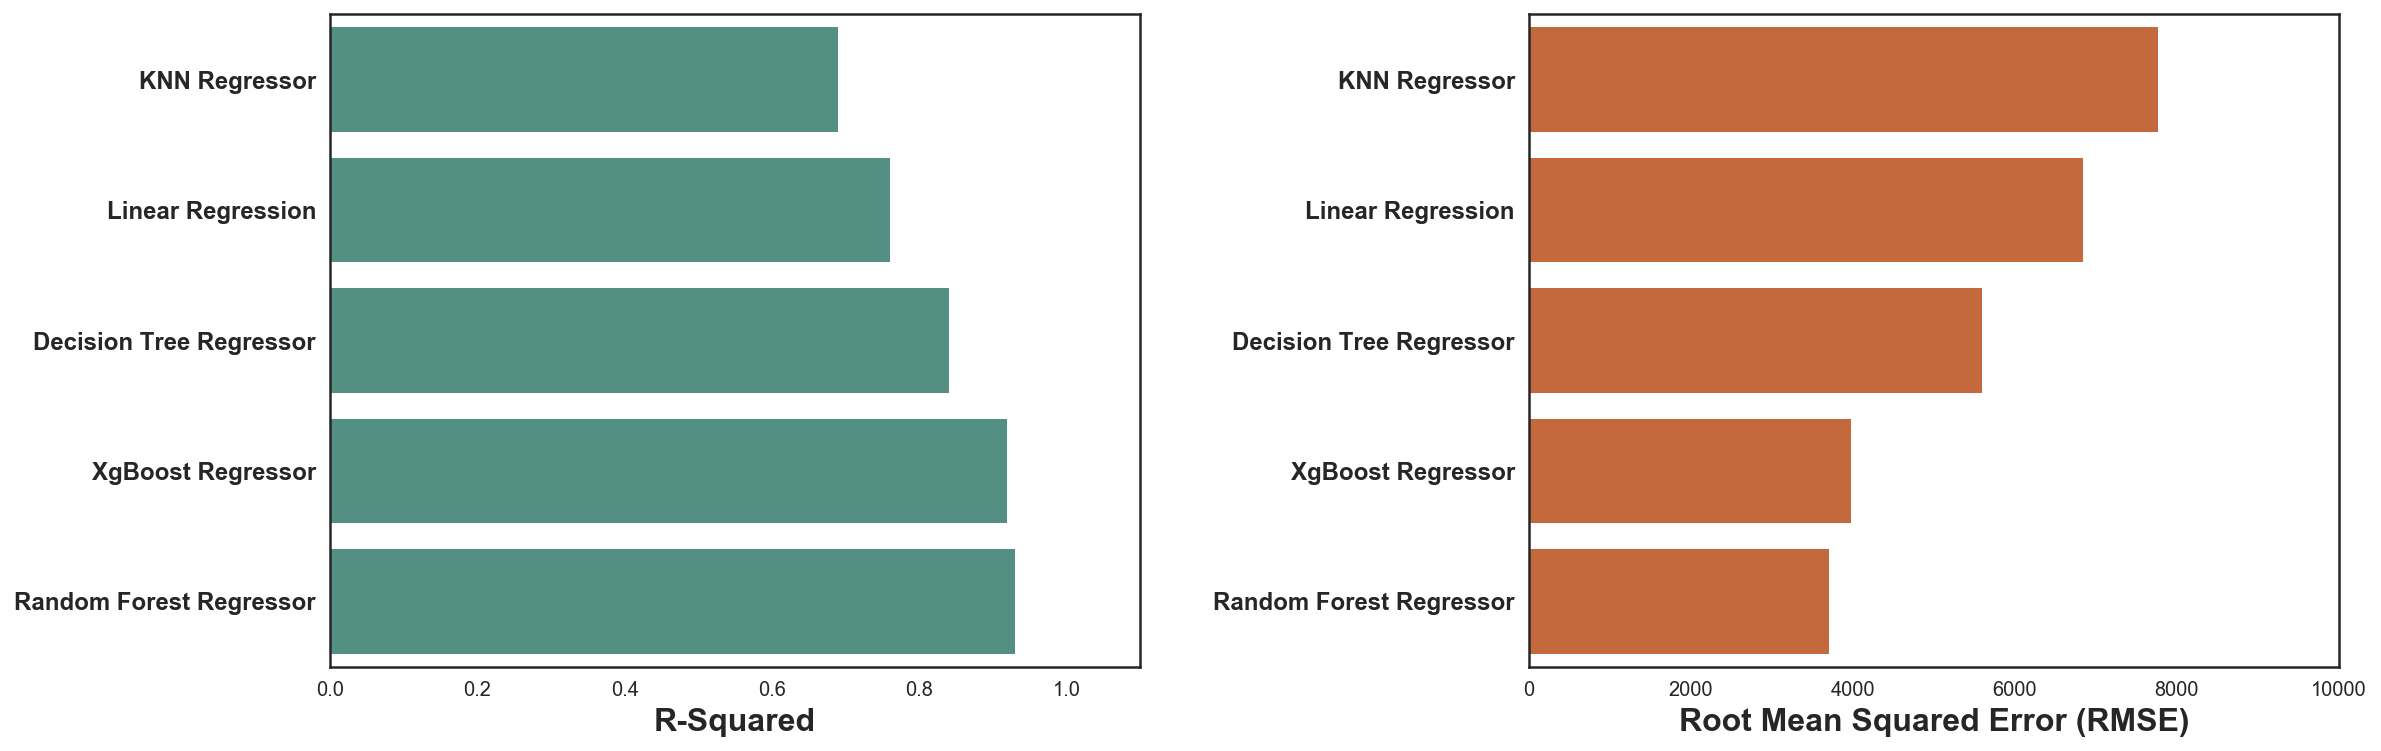

In [146]:
# Plot Model Results 
R_Squared = [0.69,0.76,0.84,0.92,0.93]
Model = ['KNN Regressor','Linear Regression','Decision Tree Regressor','XgBoost Regressor','Random Forest Regressor']
RMSE = [7771.91,6846.23,5590,3980,3702]

f, (ax1,ax2) = plt.subplots(ncols=2, figsize=(18, 6));
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.48, hspace=None)
sns.set(style="white");
sns.barplot(y=Model, x=R_Squared,orient='h',label="R-Squared",ax=ax1,color='#4a998a');
ax1.set_xlabel("R-Squared",fontweight='bold',fontsize=16);
ax1.set_yticklabels(Model,fontweight='bold',fontsize=12)
ax1.set_xlim(0,1.1)
sns.barplot(y=Model, x=RMSE ,orient='h',label="Root Mean Squared Error",ax=ax2,color='#da5f28');
ax2.set_yticklabels(Model,fontweight='bold',fontsize=12)
ax2.set_xlabel('Root Mean Squared Error (RMSE)',fontweight='bold',fontsize=16);
ax2.set_xlim(0,10000)
plt.savefig('ctscores2.png',dpi=400)

<a id='res' ></a>

### Plotting Residuals  vs Fitted Values


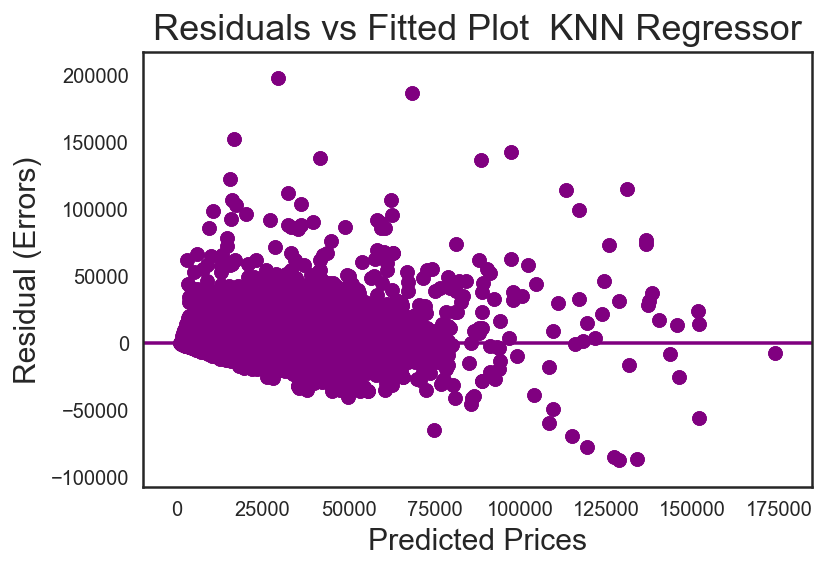

In [152]:
##KNN regressor
def residuals(prediction,colz,title):
    sns.set_style("white")
    Residual = y_test - prediction
    plt.scatter(prediction, Residual,color=str(colz))
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('Predicted Prices',fontsize=15)
    plt.ylabel('Residual (Errors)',fontsize=15)
    plt.axhline(y=0,color=str(colz))
    plt.title('Residuals vs Fitted Plot  '+ str((title)),fontsize=18)
    x = plt.scatter(prediction,Residual,color=str(colz))
    return x 

residuals(y_pred_KNR,'purple','KNN Regressor')

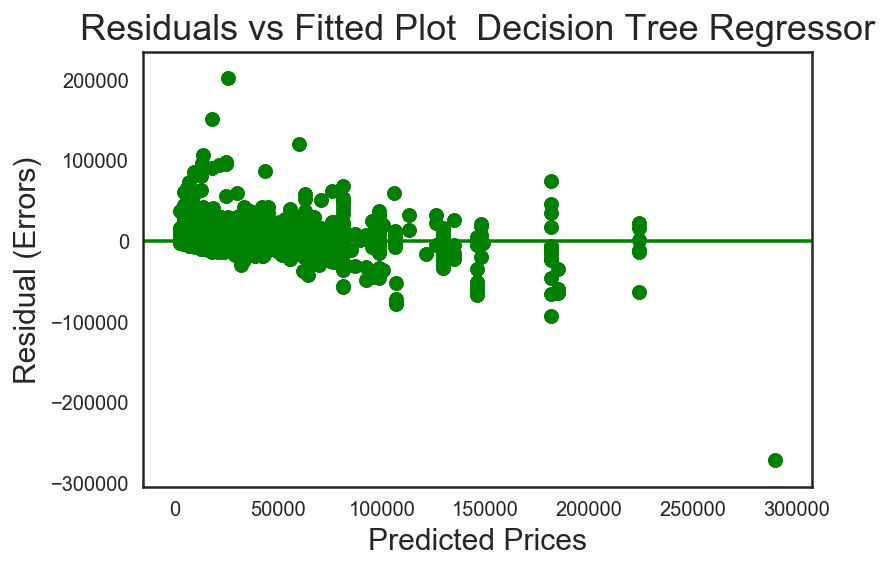

In [153]:
### Decision Tree Residuals
residuals(y_pred_dt,'green','Decision Tree Regressor')

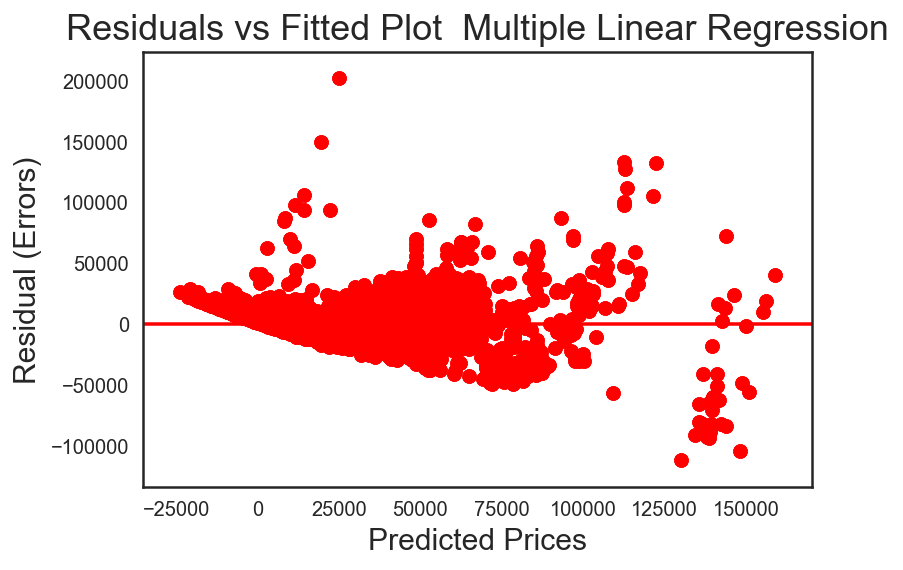

In [154]:
#Multiple Linear Regression
residuals(y_pred_linear,'red', 'Multiple Linear Regression')

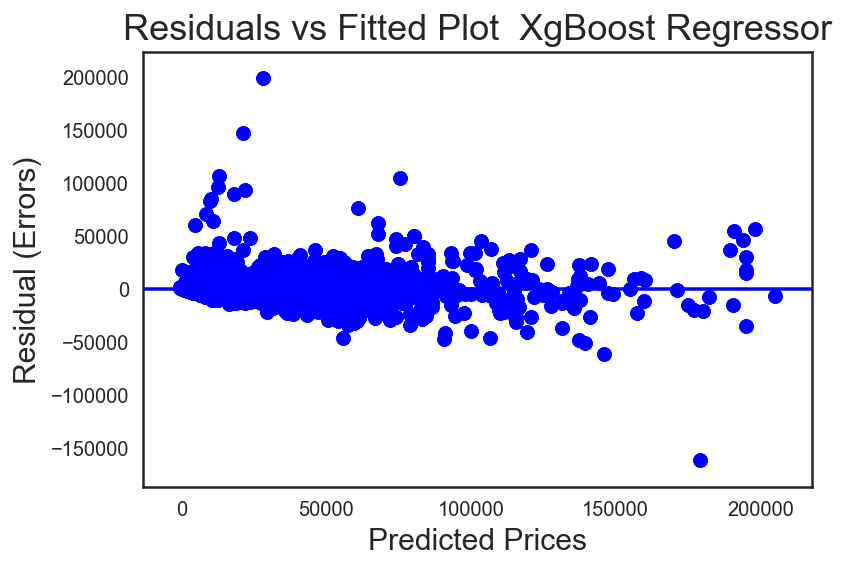

In [155]:
residuals(y_pred_xgbr,'blue','XgBoost Regressor')


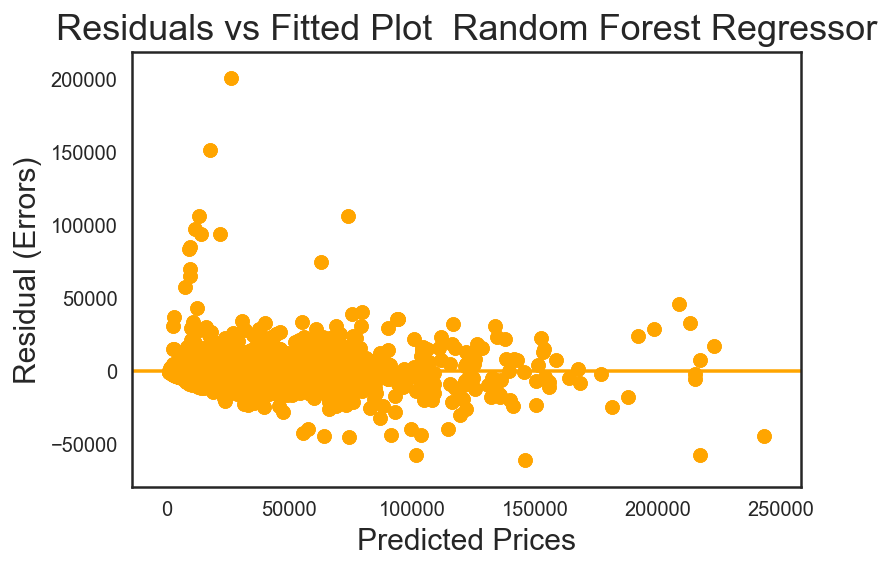

In [156]:
residuals(y_pred_rfr,'orange','Random Forest Regressor')

### Deployment 
   - You can find my flask app and html templates used for deployment in my repository. All of the tools and code used can be found in the Deployment App folder.